In [2]:
!pip3 install dask
!pip install graphviz
!pip install folium
!pip install gpxpy
!pip install gensim
!pip install prettytable
!pip install sklearn

    100% |████████████████████████████████| 112kB 2.6MB/s 
  Running setup.py bdist_wheel for gpxpy ... - done
  Stored in directory: /root/.cache/pip/wheels/7c/81/7f/effefbec600ee0ba7f29a29e38754a6e4e1e956538929fdbfd
Successfully built gpxpy


In [3]:
!pip install dask[complete]

  Running setup.py bdist_wheel for locket ... - done
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
con = sqlite3.connect(r'/content/drive/My Drive/database.sqlite') 

In [8]:
filteredData = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)
#filteredData=filteredData.iloc[0:3000,:]
#filteredData.shape               
dfScore=filteredData['Score']

def convertPositiveNegative(x):
    if x < 3:
        return 'negative'
    return 'positive'
dfPositiveNegative=dfScore.map(convertPositiveNegative)


filteredData['Score']=dfPositiveNegative
print(filteredData.head(5))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

In [0]:
sorted_data=filteredData.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [11]:
(final['Id'].size*1.0)/(filteredData['Id'].size*1.0)*100

69.25890143662969

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape
print(final.head(5))

            Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   
138690                     1                       1  positive  1076025600   
138691                     3                       4  positive  1018396800   

                                           Summary  \
138706                   E

In [13]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
                
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string

In [0]:
final=final.sort_values(by='Time')

In [17]:
final_new=final.iloc[0:40000,:]
final_new.shape

(40000, 11)

In [18]:
final_new['Score_num']=final_new.Score.map({'positive':1, 'negative':0})
Y=final_new['Score_num']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
X_train=final_new.iloc[0:30000]
Y_train=final_new['Score_num'].iloc[0:30000]

In [0]:
X_test=final_new.iloc[30001:40000]
Y_test=final_new['Score_num'].iloc[30001:40000]

# tfidF

In [0]:
count_vect = TfidfVectorizer() #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)

In [0]:
X_test_vect=count_vect.transform(X_test['CleanedText'].values)

In [0]:
from sklearn.preprocessing import Normalizer
transformer_tfidf = Normalizer().fit(X_train_vect)
X_train_vect_norm_tfidf=transformer_tfidf.transform(X_train_vect)

In [0]:
X_test_vect_norm_tfidf=transformer_tfidf.transform(X_test_vect)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

Linear Kernel

In [27]:
tuned_parameters = [{'alpha': [10**-4,10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3,10**4]}]
cv_scores = []
clf = linear_model.SGDClassifier(loss='hinge', penalty='l1')
model_auc_tfidf = GridSearchCV(clf, tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc')
model_auc_tfidf.fit(X_train_vect_norm_tfidf, Y_train)
print(model_auc_tfidf)
print(model_auc_tfidf.best_estimator_)
print(model_auc_tfidf.score(X_test_vect_norm_tfidf, Y_test))
cv_auc_train = model_auc_tfidf.cv_results_['mean_train_score']
cv_auc_cv=model_auc_tfidf.cv_results_['mean_test_score']

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       powe

In [0]:
cv_auc_train=cv_auc_train.tolist()
cv_auc_cv=cv_auc_cv.tolist()

In [26]:
cv_auc_train
cv_auc_cv


[0.9156239673378377, 0.6578456020621214, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [27]:
tuned_parameters_dict=tuned_parameters[0]
print(tuned_parameters_dict['alpha'])
tuned_parameters_list=tuned_parameters_dict['alpha']

optimal_alpha_train_auc = tuned_parameters_list[cv_auc_train.index(max(cv_auc_train))]
optimal_alpha_cv_auc=tuned_parameters_list[cv_auc_cv.index(max(cv_auc_cv))]
print("'\nThe optimal value of C for training data %d.' ",  optimal_alpha_train_auc)
print("'\nThe optimal value of C for cv data %d.' ",  optimal_alpha_cv_auc)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
'
The optimal value of C for training data %d.'  0.0001
'
The optimal value of C for cv data %d.'  0.0001


In [28]:
grid_auc_df = pd.DataFrame(
    {'C value': tuned_parameters_list,
     'AUC Train': cv_auc_train,
     'AUC Cv': cv_auc_cv
    })
grid_auc_df

,AUC Cv,AUC Train,C value
0,0.915624,0.932334,0.0001
1,0.657846,0.662567,0.0010
2,0.500000,0.500000,0.0100
3,0.500000,0.500000,0.1000
4,0.500000,0.500000,1.0000
5,0.500000,0.500000,10.0000
6,0.500000,0.500000,100.0000
7,0.500000,0.500000,1000.0000
8,0.500000,0.500000,10000.0000


In [0]:
tuned_parameters_list_log=np.log(tuned_parameters_list)
cv_auc_train_log=np.log(cv_auc_train)

In [30]:
tuned_parameters_list

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

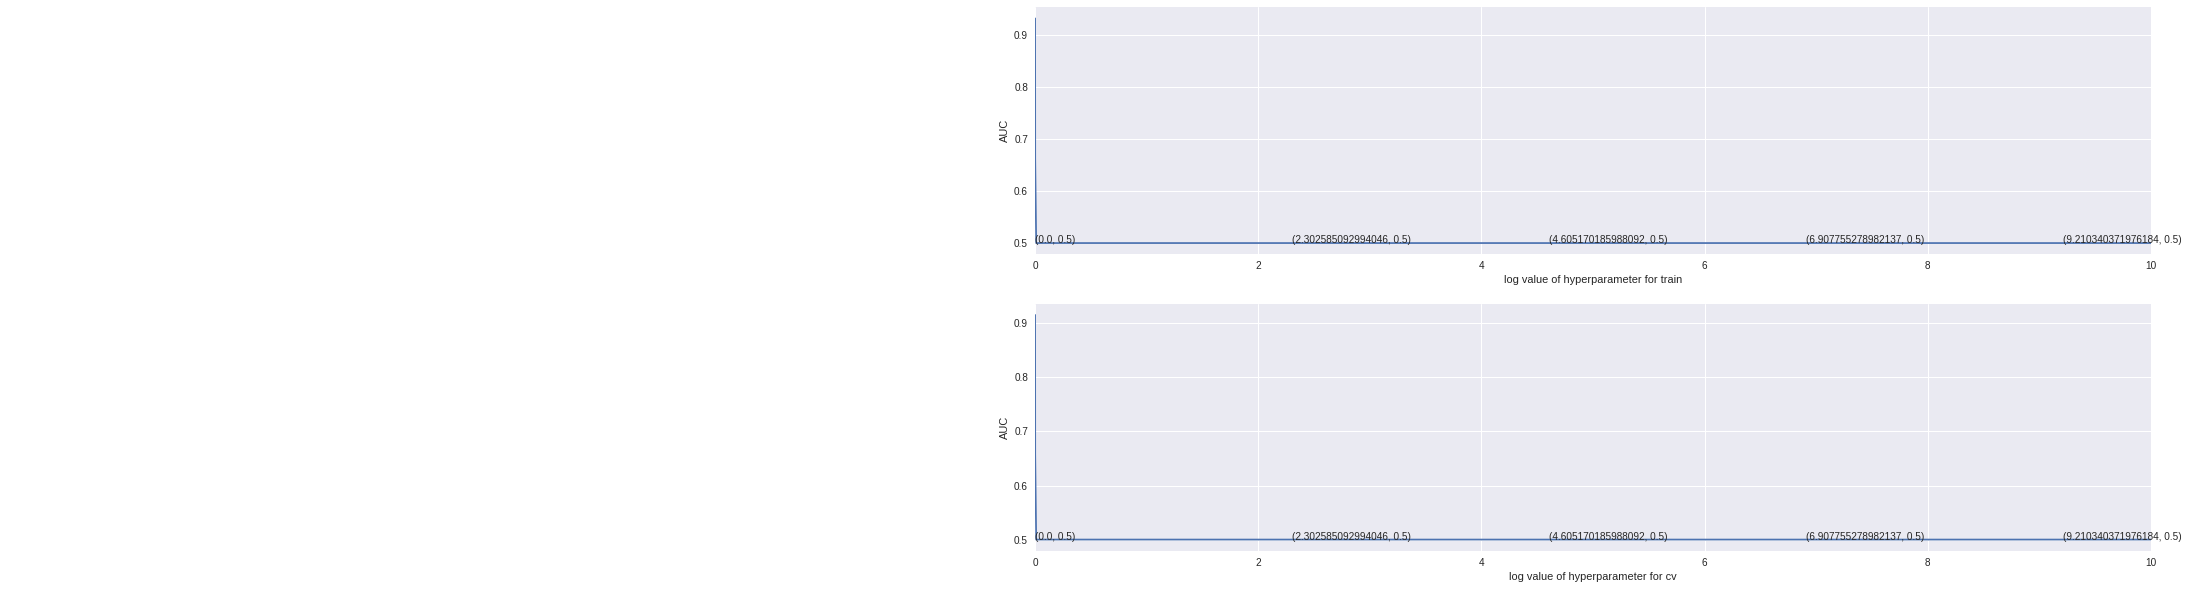

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(tuned_parameters_list, cv_auc_train)
plt.xlim([0, 10])
#plt.ylim([-0.7, 0])

for xy in zip(tuned_parameters_list_log, (cv_auc_train)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log value of hyperparameter for train')
plt.ylabel('AUC')

    
plt.subplot(2, 1, 2)    
plt.plot(tuned_parameters_list, cv_auc_cv)    
for xy in zip(tuned_parameters_list_log, np.round(cv_auc_cv,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlim([0, 10])

plt.xlabel('log value of hyperparameter for cv')
plt.ylabel('AUC')
plt.show()

In [35]:
#clf_model=MultinomialNB(alpha=0.0.001)
clf_model=linear_model.SGDClassifier(loss='hinge', penalty='l1',alpha=0.0001)
clf = clf_model.fit(X_train_vect_norm_tfidf, Y_train)

Y_predict_linear_tfidf=clf_model.predict(X_test_vect_norm_tfidf)
predict_conf_linear_tfidf=clf_model.decision_function(X_test_vect_norm_tfidf)
acc = clf_model.score(X_test_vect_norm_tfidf, Y_test)
print(acc)


0.9102910291029103


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predict_conf_linear_tfidf)

In [37]:
metrics.auc(fpr, tpr)

0.9054355557739096

In [0]:
arr=[]
arr=clf_model.coef_

In [43]:
arr.shape

(1, 21543)

In [0]:
tfidf_features= count_vect.get_feature_names()

In [45]:
feature_prob = pd.DataFrame(arr, columns = tfidf_features)
feature_prob_tr = feature_prob.T
print(feature_prob_tr.shape)

(21543, 1)


In [46]:
print("Top 20 positive Features\n",feature_prob_tr[0].sort_values(ascending = False)[0:20])
print("\n\n Top 20 negative Features\n",feature_prob_tr[0].sort_values(ascending = True)[0:20])

Top 20 positive Features
 best       4.503769
great      3.967337
delici     3.935186
perfect    3.370479
love       2.856357
excel      2.237299
yummi      2.203004
addict     2.196162
nice       2.097595
favorit    2.028276
tasti      1.960450
wonder     1.954837
awesom     1.851063
keep       1.754610
amaz       1.700700
good       1.655332
rich       1.637037
find       1.529536
fantast    1.497556
quick      1.429057
Name: 0, dtype: float64


 Top 20 negative Features
 worst        -7.860007
terribl      -5.570349
horribl      -4.825805
aw           -4.636929
threw        -4.400069
return       -4.204205
disappoint   -4.142043
refund       -3.971785
wors         -3.860653
wast         -3.622736
gross        -3.382108
bland        -2.971959
disgust      -2.799337
stale        -2.573619
unfortun     -2.549740
mayb         -2.474676
tasteless    -2.440830
wateri       -2.298213
weak         -2.283722
sorri        -2.214497
Name: 0, dtype: float64


In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

-------------------- Confusion matrix --------------------


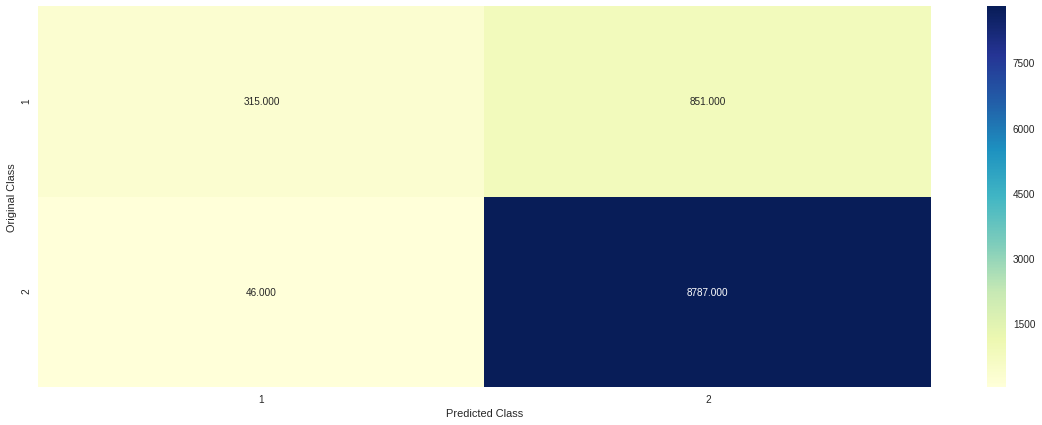

-------------------- Precision matrix (Columm Sum=1) --------------------


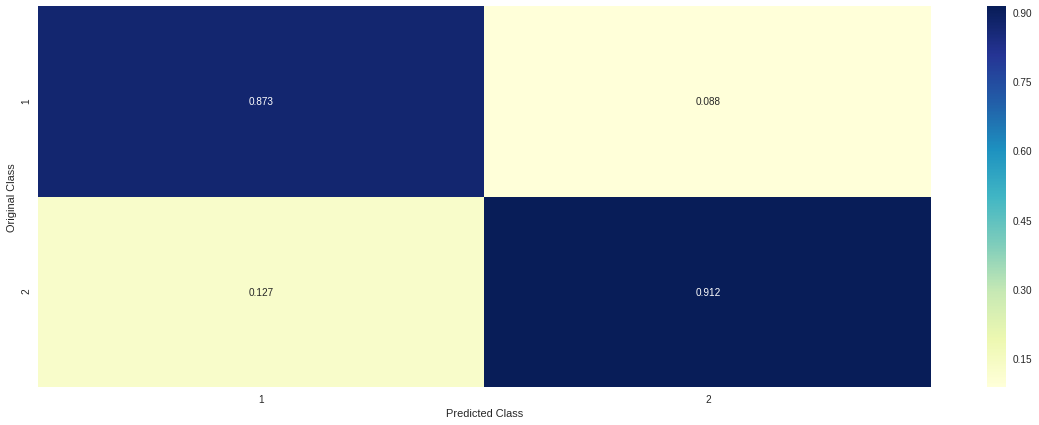

-------------------- Recall matrix (Row sum=1) --------------------


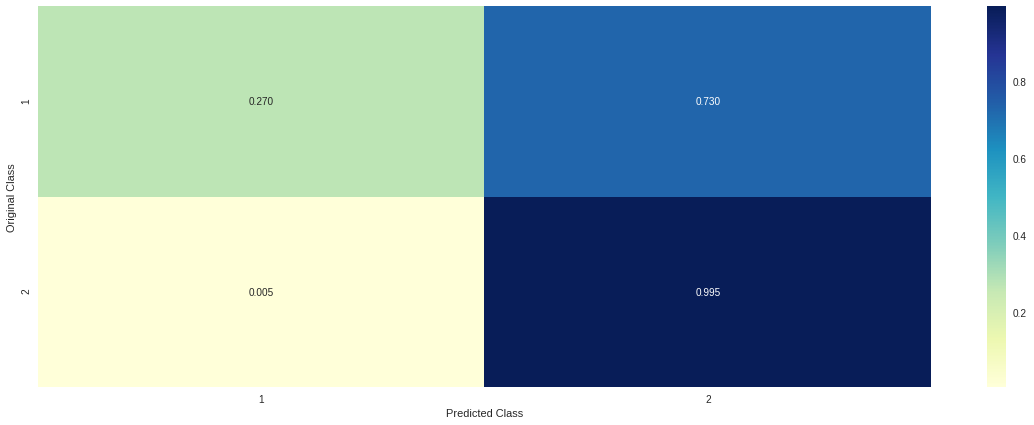

In [48]:
plot_confusion_matrix(Y_test,Y_predict_linear_tfidf)

#RBF KERNEL


In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
X_train_vect_svd =svd.fit_transform(X_train_vect_norm_tfidf)
X_test_vect_svd =svd.transform(X_test_vect_norm_tfidf)

In [0]:
tuned_parameters = [{'C': [10**-4,10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3,10**4]}]


In [51]:
cv_scores = []
clf_rbf_tfidf = SVC(kernel='rbf',gamma='auto')
model_rbf_tfidf = GridSearchCV(clf_rbf_tfidf, tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc')
model_rbf_tfidf.fit(X_train_vect_svd, Y_train)
print(model_rbf_tfidf)
print(model_rbf_tfidf.best_estimator_)
print(model_rbf_tfidf.score(X_test_vect_svd, Y_test))


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)
SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8918072703737097


In [0]:
cv_auc_train_rbf = model_rbf_tfidf.cv_results_['mean_train_score']
cv_auc_cv_rbf=model_rbf_tfidf.cv_results_['mean_test_score']

In [0]:
cv_auc_train_rbf=cv_auc_train_rbf.tolist()
cv_auc_cv_rbf=cv_auc_cv_rbf.tolist()

In [59]:
print(cv_auc_train_rbf)
print(cv_auc_cv_rbf)

[0.7665602528444219, 0.7666097659630184, 0.8468239817514209, 0.9019254583840132, 0.906172165066773, 0.9063005439306113, 0.9072404582318352, 0.9105326075534224, 0.9174343720274614]
[0.7610957859841958, 0.7611238123245657, 0.8394695034299217, 0.8930562366353106, 0.8973687472148747, 0.8976345445518038, 0.898160289129546, 0.900593700585494, 0.9026933097372865]


In [55]:
tuned_parameters_dict=tuned_parameters[0]
print(tuned_parameters_dict['C'])
tuned_parameters_list=tuned_parameters_dict['C']

optimal_C_train_auc = tuned_parameters_list[cv_auc_train_rbf.index(max(cv_auc_train_rbf))]
optimal_C_cv_auc=tuned_parameters_list[cv_auc_cv_rbf.index(max(cv_auc_cv_rbf))]
print("'\nThe optimal value of C for training data %d.' ",  optimal_C_train_auc)
print("'\nThe optimal value of C for cv data %d.' ",  optimal_C_cv_auc)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
'
The optimal value of C for training data %d.'  10000
'
The optimal value of C for cv data %d.'  10000


In [56]:
grid_auc_df = pd.DataFrame(
    {'C value': tuned_parameters_list,
     'AUC Train': cv_auc_cv_rbf,
     'AUC Cv': cv_auc_cv
    })
grid_auc_df

,AUC Cv,AUC Train,C value
0,0.915624,0.761096,0.0001
1,0.657846,0.761124,0.0010
2,0.500000,0.839470,0.0100
3,0.500000,0.893056,0.1000
4,0.500000,0.897369,1.0000
5,0.500000,0.897635,10.0000
6,0.500000,0.898160,100.0000
7,0.500000,0.900594,1000.0000
8,0.500000,0.902693,10000.0000


In [0]:
tuned_parameters_list_log=np.log(tuned_parameters_list)


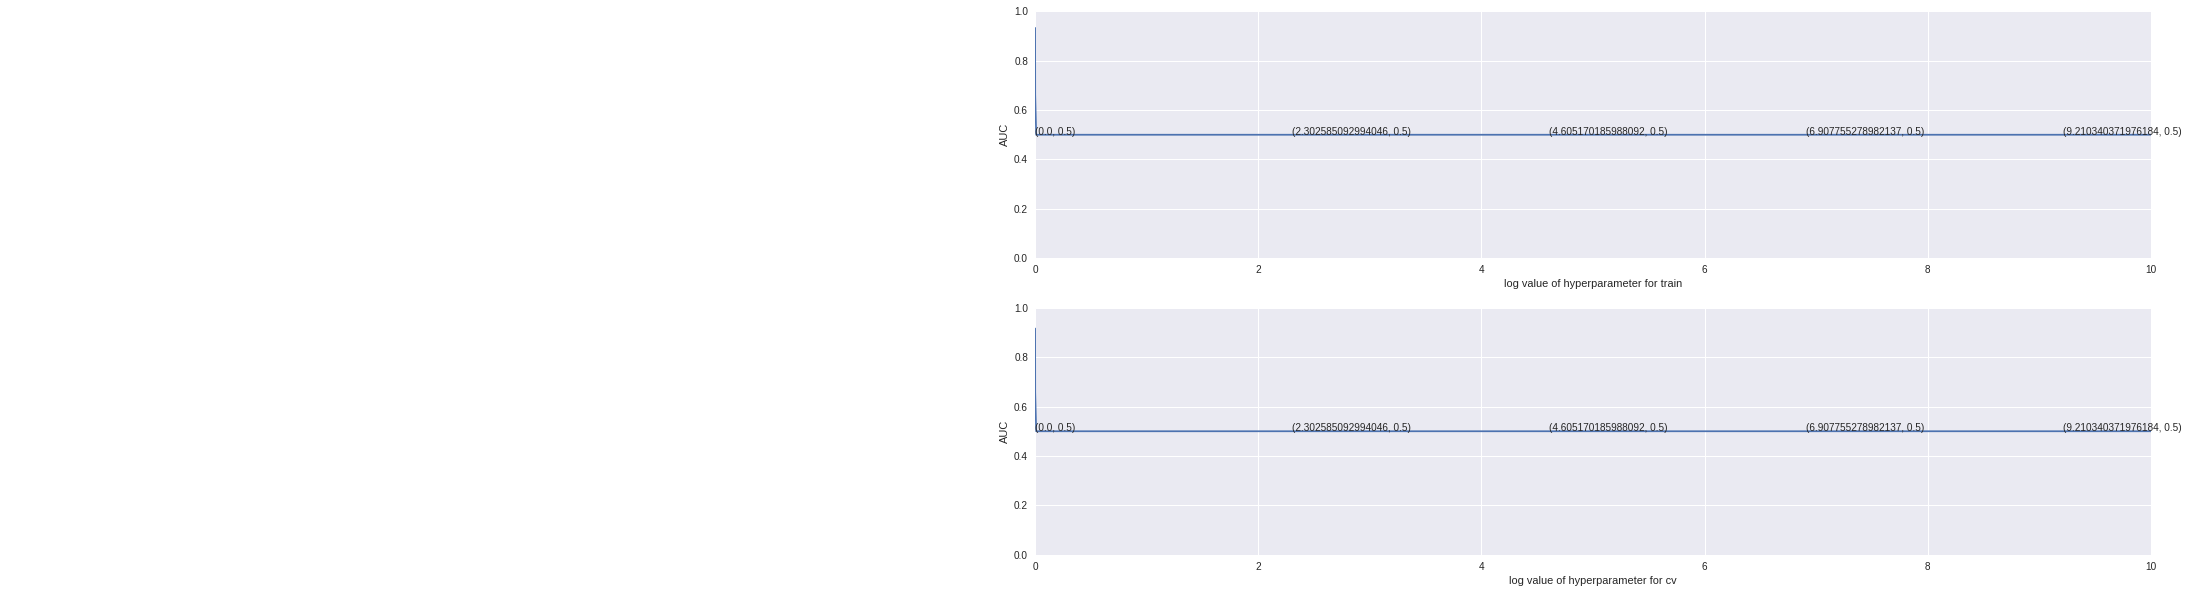

In [78]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(tuned_parameters_list, cv_auc_train)
plt.xlim([0, 10])
plt.ylim([0, 1])

for xy in zip(tuned_parameters_list_log, (cv_auc_train)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log value of hyperparameter for train')
plt.ylabel('AUC')

    
plt.subplot(2, 1, 2)    
plt.plot(tuned_parameters_list, cv_auc_cv)    
for xy in zip(tuned_parameters_list_log, np.round(cv_auc_cv,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlim([0, 10])
plt.ylim([0, 1])

plt.xlabel('log value of hyperparameter for cv')
plt.ylabel('AUC')
plt.show()

In [61]:
clf_model_tfidf_rbf=SVC(kernel='rbf',gamma='auto',C=10000)
clf_model_tfidf_rbf.fit(X_train_vect_svd, Y_train)
Y_predict=clf_model_tfidf_rbf.predict(X_test_vect_svd)
Y_conf_rbf_tfidf=clf_model_tfidf_rbf.decision_function(X_test_vect_svd)
acc = clf_model_tfidf_rbf.score(X_test_vect_svd, Y_test)
print(acc)

0.9074907490749075


In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_conf_rbf_tfidf)

In [63]:
metrics.auc(fpr, tpr)

0.8918072703737097

-------------------- Confusion matrix --------------------


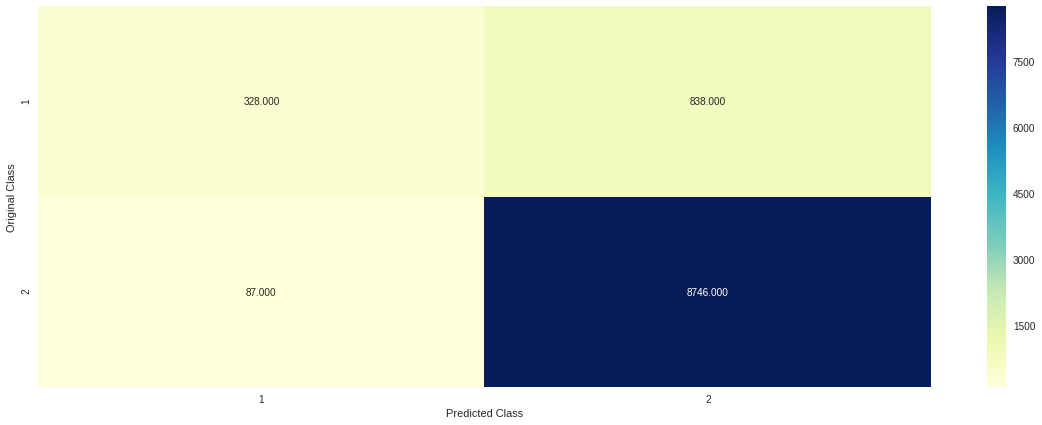

-------------------- Precision matrix (Columm Sum=1) --------------------


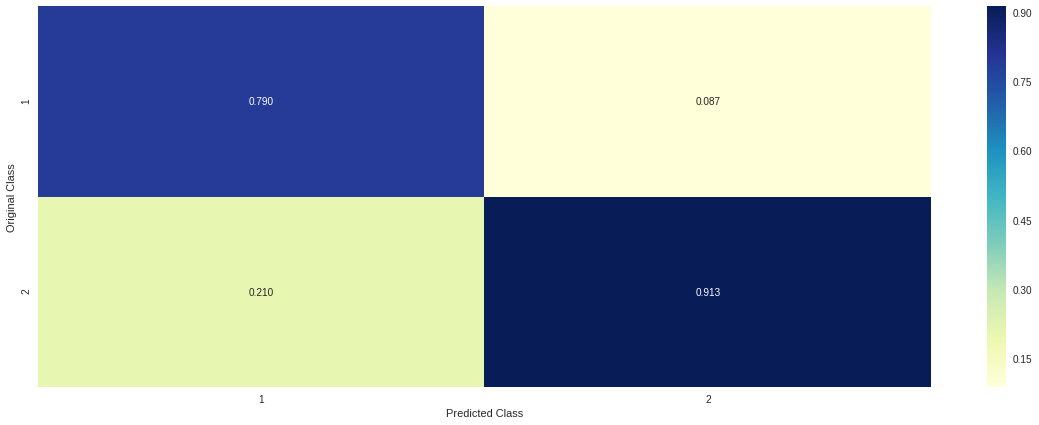

-------------------- Recall matrix (Row sum=1) --------------------


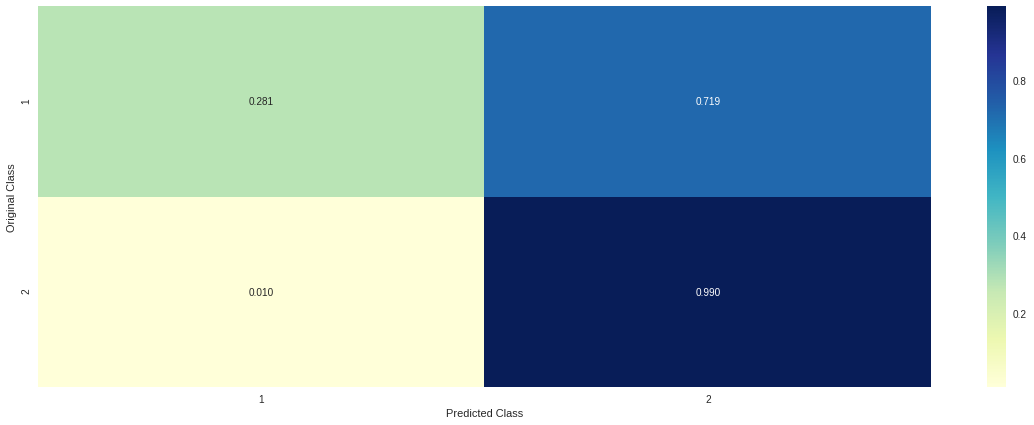

In [64]:
plot_confusion_matrix(Y_test,Y_predict)

BOW

In [0]:
count_vect_bow=CountVectorizer() #in scikit-learn
X_train_vect_bow = count_vect_bow.fit_transform(X_train['CleanedText'].values)

In [0]:
X_test_vect_bow=count_vect_bow.transform(X_test['CleanedText'].values)

In [30]:
from sklearn.preprocessing import Normalizer
transformer_bow = Normalizer().fit(X_train_vect_bow)
print(transformer_bow)
X_train_vect_norm_bow=transformer_bow.transform(X_train_vect_bow)

Normalizer(copy=True, norm='l2')


In [0]:
X_test_vect_norm_bow=transformer_bow.transform(X_test_vect_bow)

In [32]:
tuned_parameters = [{'alpha': [10**-4,10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3,10**4]}]
cv_scores = []
clf_bow = linear_model.SGDClassifier(loss='hinge', penalty='l2')
model_auc_bow = GridSearchCV(clf, tuned_parameters, cv=5,return_train_score='True',scoring='roc_auc')
model_auc_bow.fit(X_train_vect_bow, Y_train)
print(model_auc_bow)
print(model_auc_bow.best_estimator_)
print(model_auc_bow.score(X_test_vect_bow, Y_test))
cv_auc_train_bow = model_auc_bow.cv_results_['mean_train_score']
cv_auc_cv_bow=model_auc_bow.cv_results_['mean_test_score']

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       powe

In [73]:
tuned_parameters_dict=tuned_parameters[0]
print(tuned_parameters_dict['alpha'])
tuned_parameters_list=tuned_parameters_dict['alpha']
print(tuned_parameters_list)
optimal_alpha_train_bow = tuned_parameters_list[cv_auc_train_bow.index(max(cv_auc_train_bow))]
optimal_alpha_cv_bow=tuned_parameters_list[cv_auc_cv_bow.index(max(cv_auc_cv_bow))]
print("'\nThe optimal value of alpha for training data %d.' ",  optimal_alpha_train_bow)
print("'\nThe optimal value of alpha for cv data %d.' ",  optimal_alpha_cv_bow)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
'
The optimal value of alpha for training data %d.'  0.0001
'
The optimal value of alpha for cv data %d.'  0.0001


In [74]:
grid_auc_df = pd.DataFrame(
    {'Alpha value': tuned_parameters_list,
     'AUC Train': cv_auc_train_bow,
     'AUC Cv': cv_auc_cv_bow
    })
grid_auc_df

,AUC Cv,AUC Train,Alpha value
0,0.881764,0.941720,0.0001
1,0.844357,0.864906,0.0010
2,0.581464,0.586188,0.0100
3,0.622066,0.621936,0.1000
4,0.500000,0.500000,1.0000
5,0.500000,0.500000,10.0000
6,0.500000,0.500000,100.0000
7,0.500000,0.500000,1000.0000
8,0.500000,0.500000,10000.0000


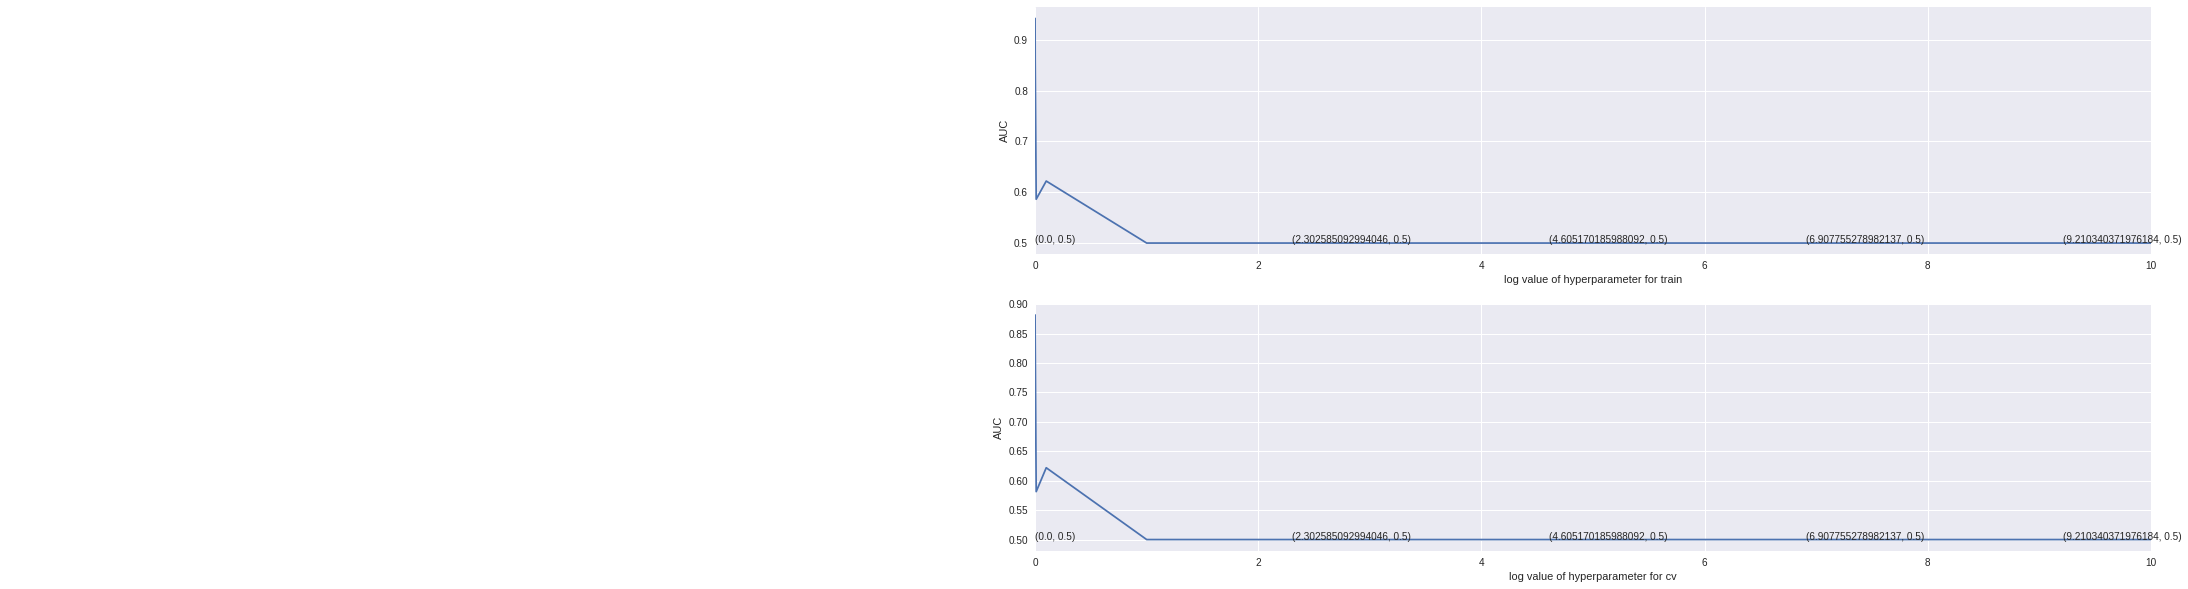

In [79]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(tuned_parameters_list, cv_auc_train_bow)
plt.xlim([0, 10])
#plt.ylim([-0.7, 0])

for xy in zip(tuned_parameters_list_log, (cv_auc_train_bow)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log value of hyperparameter for train')
plt.ylabel('AUC')

    
plt.subplot(2, 1, 2)    
plt.plot(tuned_parameters_list, cv_auc_cv_bow)    
for xy in zip(tuned_parameters_list_log, np.round(cv_auc_cv_bow,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlim([0, 10])

plt.xlabel('log value of hyperparameter for cv')
plt.ylabel('AUC')
plt.show()

In [80]:
#clf_model=MultinomialNB(alpha=0.0.001)
clf_model_bow=linear_model.SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001)
clf_model_bow.fit(X_train_vect_bow, Y_train)

Y_predict=clf_model_bow.predict(X_test_vect_bow)
Y_predict_conf_linear_bow=clf_model_bow.decision_function(X_test_vect_bow)
acc = clf_model_bow.score(X_test_vect_bow, Y_test)
print(acc)

0.9140914091409141


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [0]:
arr_bow=[]
arr_bow=clf_model_bow.coef_

In [0]:
bow_features= count_vect_bow.get_feature_names()

In [83]:
feature_prob = pd.DataFrame(arr_bow, columns = bow_features)
feature_prob_tr = feature_prob.T
print(feature_prob_tr.shape)

(21543, 1)


In [84]:
print("Top 20 positive Features\n",feature_prob_tr[0].sort_values(ascending = False)[0:20])
print("\n\n Top 20 negative Features\n",feature_prob_tr[0].sort_values(ascending = True)[0:20])

Top 20 positive Features
 amaz         2.450347
perfect      2.251671
smooth       1.854317
beat         1.854317
hook         1.854317
easier       1.854317
delici       1.854317
skeptic      1.655640
goe          1.589414
addict       1.589414
allergi      1.589414
beauti       1.589414
solv         1.589414
uniqu        1.589414
worri        1.523189
sparkl       1.523189
best         1.523189
definit      1.456963
complaint    1.456963
crave        1.456963
Name: 0, dtype: float64


 Top 20 negative Features
 worst        -4.039762
wors         -2.913927
horribl      -2.847701
terribl      -2.582799
disappoint   -2.516573
bland        -2.516573
aw           -2.384122
unfortun     -2.317896
unpleas      -2.185445
sorri        -2.119219
weak         -2.119219
tasteless    -1.854317
silver       -1.788091
claim        -1.788091
fed          -1.721866
cheap        -1.721866
wateri       -1.655640
wast         -1.655640
yuck         -1.655640
fell         -1.655640
Name: 0, dtype: float

In [85]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_predict_conf_linear_bow)
metrics.auc(fpr, tpr)

0.8708831822968562

-------------------- Confusion matrix --------------------


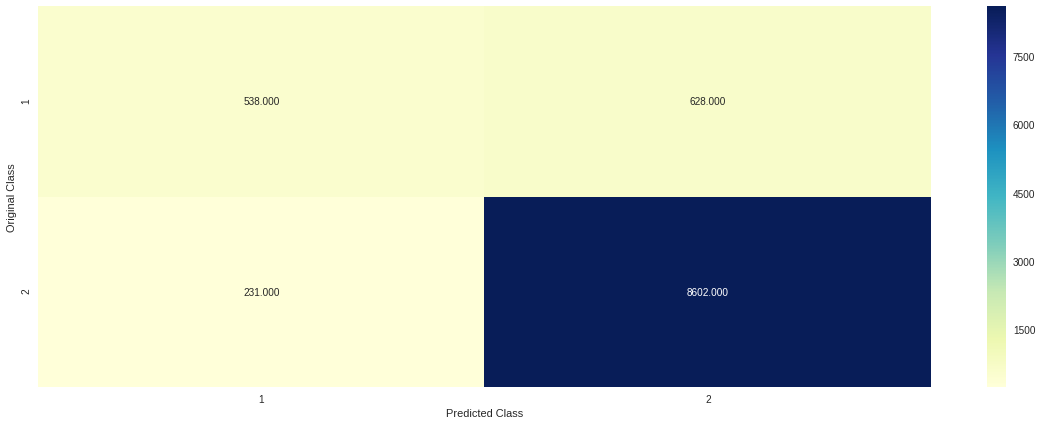

-------------------- Precision matrix (Columm Sum=1) --------------------


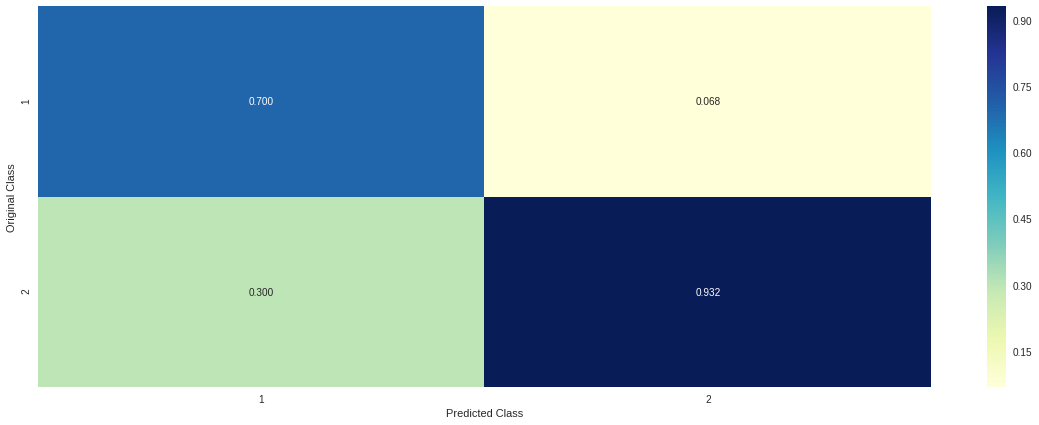

-------------------- Recall matrix (Row sum=1) --------------------


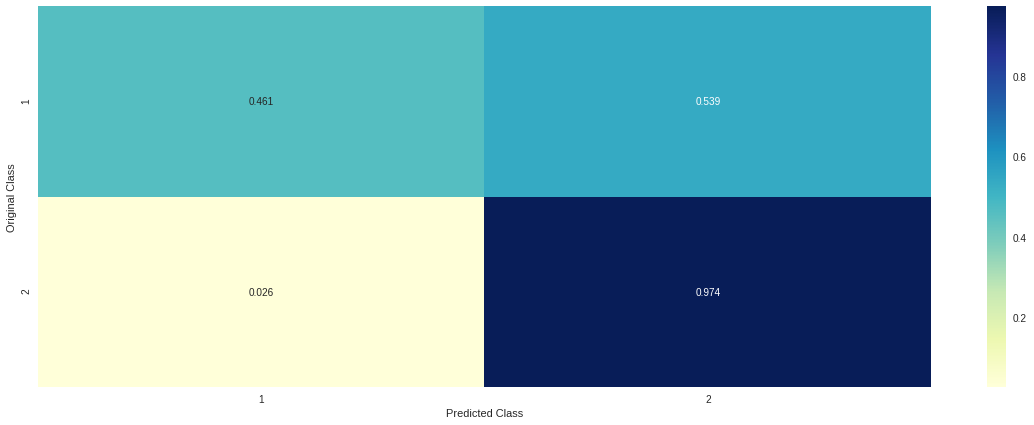

In [86]:
plot_confusion_matrix(Y_test,Y_predict)

svm with rbf kernel using bow 

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
X_train_bow_svd =svd.fit_transform(X_train_vect_bow)
X_test_bow_svd =svd.transform(X_test_vect_bow)

In [88]:
tuned_parameters = [{'C': [10**-4,10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3,10**4]}]
cv_scores = []
clf_bow_rbf = SVC(kernel='rbf',gamma='auto')
model_rbf_bow = GridSearchCV(clf_bow_rbf, tuned_parameters, cv=3,return_train_score='True',scoring='roc_auc')
model_rbf_bow.fit(X_train_bow_svd, Y_train)
print(model_rbf_bow)
print(model_rbf_bow.best_estimator_)
print(model_rbf_bow.score(X_test_bow_svd, Y_test))
cv_rbf_train_bow = model_rbf_bow.cv_results_['mean_train_score']
cv_rbf_cv_bow=model_rbf_bow.cv_results_['mean_test_score']

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8756691488471328


In [0]:
cv_bow_train_rbf = model_rbf_bow.cv_results_['mean_train_score']
cv_bow_cv_rbf=model_rbf_bow.cv_results_['mean_test_score']

In [0]:
cv_bow_train_rbf=cv_bow_train_rbf.tolist()
cv_bow_cv_rbf=cv_bow_cv_rbf.tolist()

In [91]:
print(cv_bow_train_rbf)
print(cv_bow_cv_rbf)

[0.7331559609628221, 0.880712884409475, 0.9138288793095439, 0.9154796702605482, 0.9156116812105332, 0.9337199432311548, 0.9721518345663419, 0.9951726865833378, 0.9998950940931435]
[0.7257358561764508, 0.8585038129088691, 0.8773363977752633, 0.8776554807829484, 0.8777716402746403, 0.879879912982977, 0.8678309124331492, 0.8230607396065432, 0.7870350754440627]


In [92]:
tuned_parameters_dict=tuned_parameters[0]
print(tuned_parameters_dict['C'])
tuned_parameters_list=tuned_parameters_dict['C']

optimal_C_train_rbf_bow = tuned_parameters_list[cv_bow_train_rbf.index(max(cv_bow_train_rbf))]
optimal_C_cv_rbf_bow=tuned_parameters_list[cv_bow_cv_rbf.index(max(cv_bow_cv_rbf))]
print("'\nThe optimal value of C for training data %d.' ",  optimal_C_train_rbf_bow)
print("'\nThe optimal value of C for cv data %d.' ",  optimal_C_cv_rbf_bow)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
'
The optimal value of C for training data %d.'  10000
'
The optimal value of C for cv data %d.'  10


In [93]:
grid_auc_df = pd.DataFrame(
    {'C value': tuned_parameters_list,
     'AUC Train': cv_bow_train_rbf,
     'AUC Cv': cv_bow_cv_rbf
    })
grid_auc_df

,AUC Cv,AUC Train,C value
0,0.725736,0.733156,0.0001
1,0.858504,0.880713,0.0010
2,0.877336,0.913829,0.0100
3,0.877655,0.915480,0.1000
4,0.877772,0.915612,1.0000
5,0.879880,0.933720,10.0000
6,0.867831,0.972152,100.0000
7,0.823061,0.995173,1000.0000
8,0.787035,0.999895,10000.0000


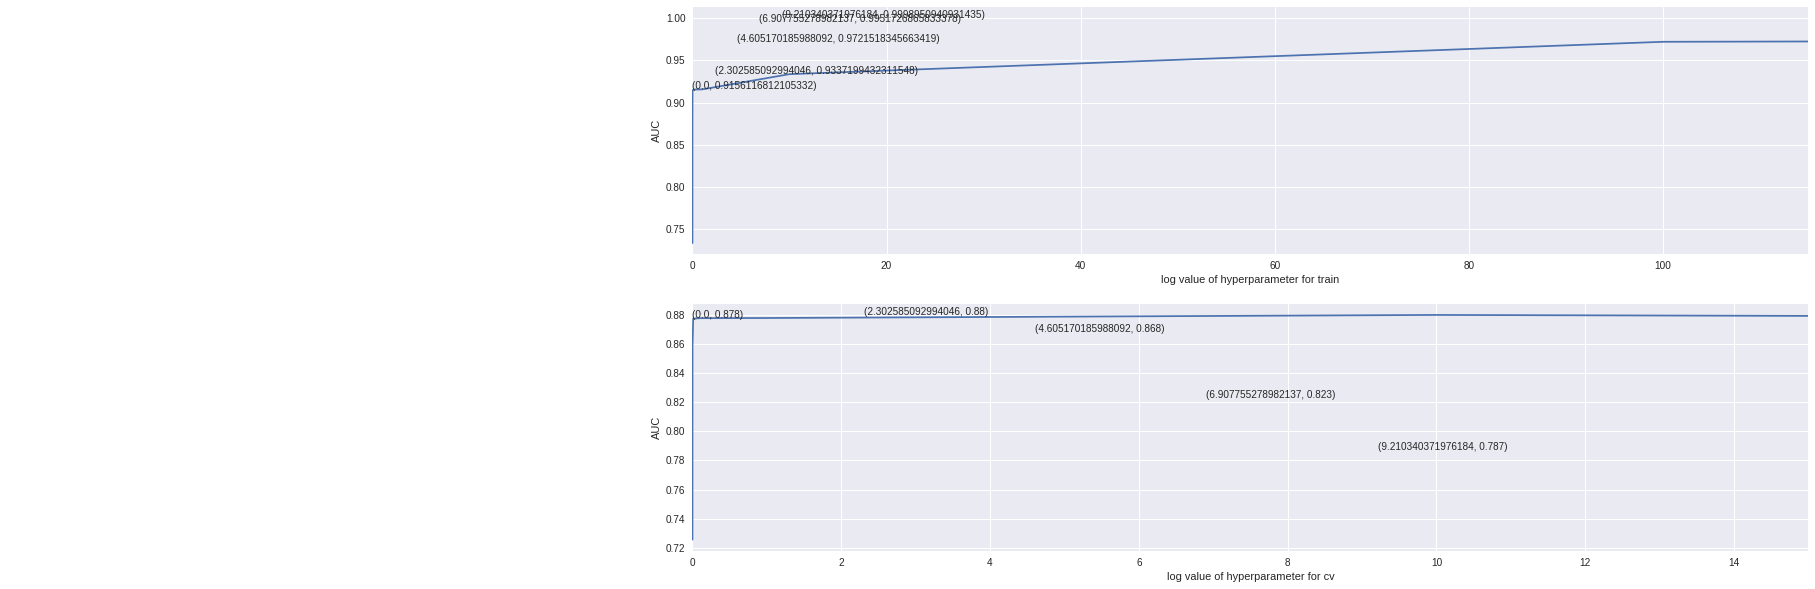

In [96]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(tuned_parameters_list, cv_bow_train_rbf)
plt.xlim([0, 115])
#plt.ylim([-0.7, 0])

for xy in zip(tuned_parameters_list_log, (cv_bow_train_rbf)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log value of hyperparameter for train')
plt.ylabel('AUC')

    
plt.subplot(2, 1, 2)    
plt.plot(tuned_parameters_list, cv_bow_cv_rbf)    
for xy in zip(tuned_parameters_list_log, np.round(cv_bow_cv_rbf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlim([0, 15])

plt.xlabel('log value of hyperparameter for cv')
plt.ylabel('AUC')
plt.show()

In [98]:
clf_model_bow_rbf=SVC(kernel='rbf',gamma='auto',C=10)
clf_model_bow_rbf.fit(X_train_bow_svd, Y_train)
Y_predict=clf_model_bow_rbf.predict(X_test_bow_svd)
Y_predict_conf_rbf_bow=clf_model_bow_rbf.decision_function(X_test_bow_svd) 
acc = clf_model_bow_rbf.score(X_test_bow_svd, Y_test)
print(acc)

0.8946894689468947


In [99]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_predict_conf_rbf_bow)
metrics.auc(fpr, tpr)

0.8756691488471328

-------------------- Confusion matrix --------------------


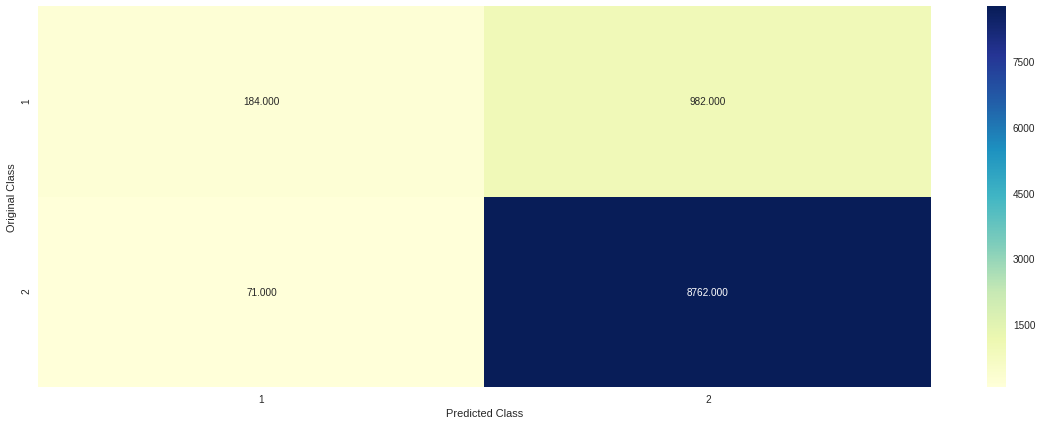

-------------------- Precision matrix (Columm Sum=1) --------------------


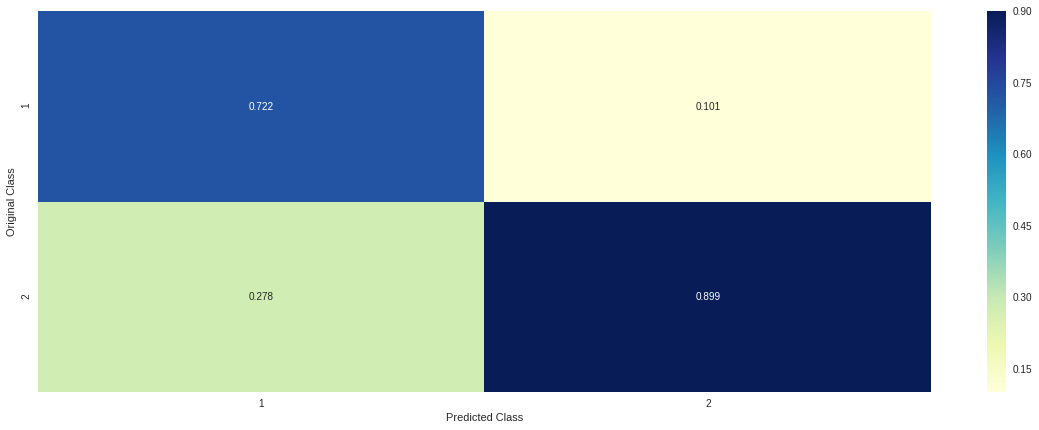

-------------------- Recall matrix (Row sum=1) --------------------


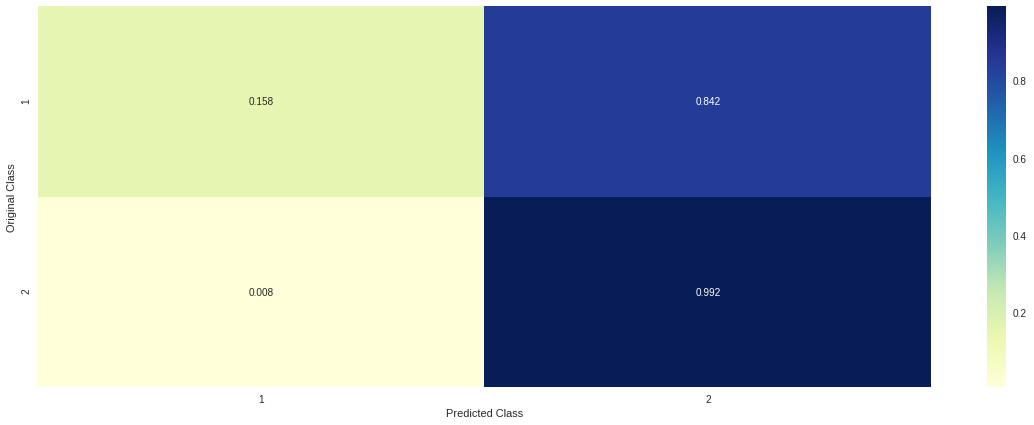

In [100]:
plot_confusion_matrix(Y_test,Y_predict)

word2vec

In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
final_new['CleanedText']=final_new['CleanedText'].str.decode("utf-8")

In [0]:
X_train_word2vec=final_new.iloc[0:30000]
Y_train_word2vec=final_new['Score_num'].iloc[0:30000]

X_test_word2vec=final_new.iloc[30001:40000]
Y_test_word2vec=final_new['Score_num'].iloc[30001:40000]

In [0]:
list_of_sent_X_train_word2vec=[]
list_of_sent_X_test_word2vec=[]

for sent in X_train_word2vec['CleanedText'].values:
    list_of_sent_X_train_word2vec.append(sent.split())
    


for sent in X_test_word2vec['CleanedText'].values:
    list_of_sent_X_test_word2vec.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent_X_train_word2vec,min_count=5,size=50, workers=4)

In [0]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

In [0]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

In [0]:
from sklearn.preprocessing import Normalizer
transformer_word2vec = Normalizer().fit(sent_vectors_train)
X_train_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_train)
X_test_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_test)

In [41]:
print(X_train_vect_norm_word2vec.shape)
print(X_test_vect_norm_word2vec.shape)
print(Y_train_word2vec.shape)

(30000, 50)
(9999, 50)
(30000,)


WORD2VEC WITH LINEAR KERNAL

In [42]:
tuned_parameters = [{'alpha': [10**-5,10**-4,10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3,10**4]}]
cv_scores = []
clf_word2vec = linear_model.SGDClassifier(loss='hinge', penalty='l2')
model_auc_word2vec = GridSearchCV(clf_word2vec, tuned_parameters, cv=10,return_train_score='True',scoring='roc_auc')
model_auc_word2vec.fit(X_train_vect_norm_word2vec, Y_train)
print(model_auc_word2vec)
print(model_auc_word2vec.best_estimator_)
print(model_auc_word2vec.score(X_test_vect_norm_word2vec, Y_test))
cv_auc_train_word2vec = model_auc_word2vec.cv_results_['mean_train_score']
cv_auc_cv_word2vec=model_auc_word2vec.cv_results_['mean_test_score']

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)
SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
    

In [0]:
cv_auc_train_word2vec=cv_auc_train_word2vec.tolist()
cv_auc_cv_word2vec=cv_auc_cv_word2vec.tolist()

In [0]:
print(cv_auc_train_word2vec)
print(cv_auc_cv_word2vec)

In [113]:
tuned_parameters_dict=tuned_parameters[0]
#print(tuned_parameters_dict['alpha'])
tuned_parameters_list=tuned_parameters_dict['alpha']
print(tuned_parameters_list)

optimal_alpha_train_word2vec = tuned_parameters_list[cv_auc_train_word2vec.index(max(cv_auc_train_word2vec))]
optimal_alpha_cv_word2vec=tuned_parameters_list[cv_auc_cv_word2vec.index(max(cv_auc_cv_word2vec))]

print("'\nThe optimal value of alpha for training data %d.' ",  optimal_alpha_train_word2vec)
print("'\nThe optimal value of alpha for cv data %d.' ",  optimal_alpha_cv_word2vec)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
'
The optimal value of alpha for training data %d.'  0.1
'
The optimal value of alpha for cv data %d.'  0.1


In [114]:
grid_auc_df = pd.DataFrame(
    {'Alpha value': tuned_parameters_list,
     'AUC Train': cv_auc_train_word2vec,
     'AUC Cv': cv_auc_cv_word2vec
    })
grid_auc_df

,AUC Cv,AUC Train,Alpha value
0,0.865479,0.866730,0.00001
1,0.875825,0.878989,0.00010
2,0.877530,0.880192,0.00100
3,0.877807,0.880182,0.01000
4,0.878128,0.880644,0.10000
5,0.876780,0.879897,1.00000
6,0.815913,0.815896,10.00000
7,0.555901,0.556122,100.00000
8,0.555901,0.556122,1000.00000
9,0.555901,0.556122,10000.00000


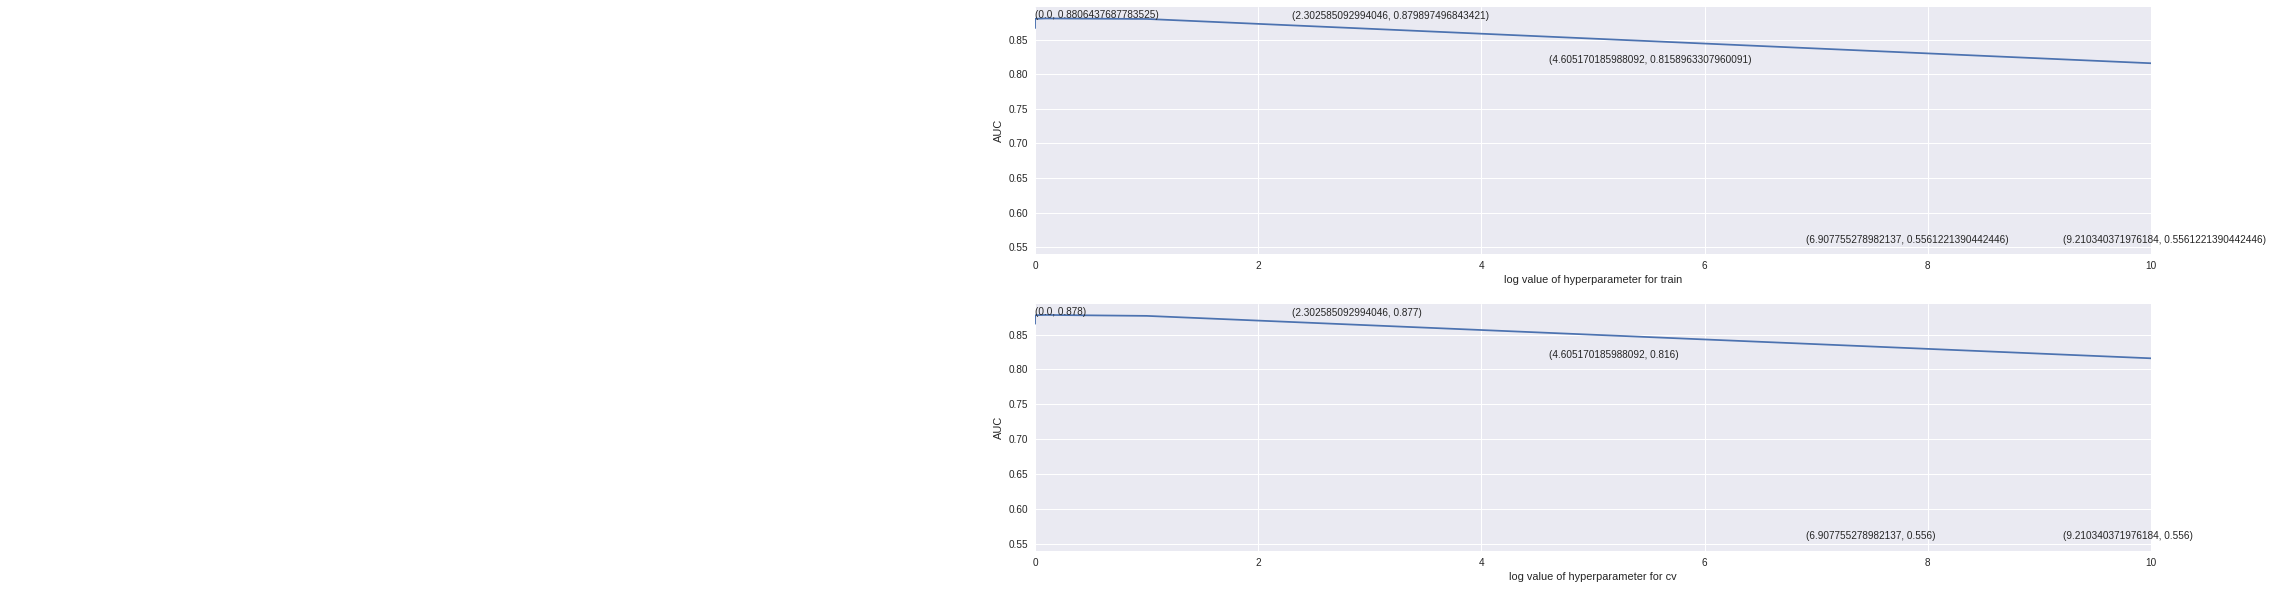

In [115]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(tuned_parameters_list, cv_auc_train_word2vec)
plt.xlim([0, 10])
#plt.ylim([-0.7, 0])

for xy in zip(tuned_parameters_list_log, (cv_auc_train_word2vec)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log value of hyperparameter for train')
plt.ylabel('AUC')

    
plt.subplot(2, 1, 2)    
plt.plot(tuned_parameters_list, cv_auc_cv_word2vec)    
for xy in zip(tuned_parameters_list_log, np.round(cv_auc_cv_word2vec,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlim([0, 10])

plt.xlabel('log value of hyperparameter for cv')
plt.ylabel('AUC')
plt.show()

In [131]:
clf_model_word2vec=linear_model.SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001)
clf_model_word2vec.fit(X_train_vect_norm_word2vec, Y_train)

Y_predict_linear_word2vec=clf_model_word2vec.predict(X_test_vect_norm_word2vec)
Y_conf_linear_word2vec=clf_model_word2vec.decision_function(X_test_vect_norm_word2vec)
acc = clf_model_word2vec.score(X_test_vect_norm_word2vec, Y_test)
print(acc)

0.8901890189018902


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [132]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_conf_linear_word2vec)
metrics.auc(fpr, tpr)

0.8696779521826674

-------------------- Confusion matrix --------------------


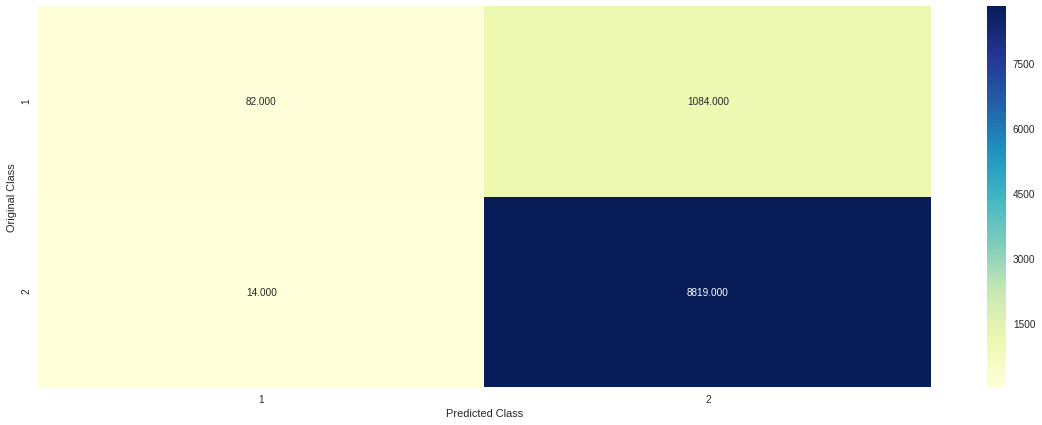

-------------------- Precision matrix (Columm Sum=1) --------------------


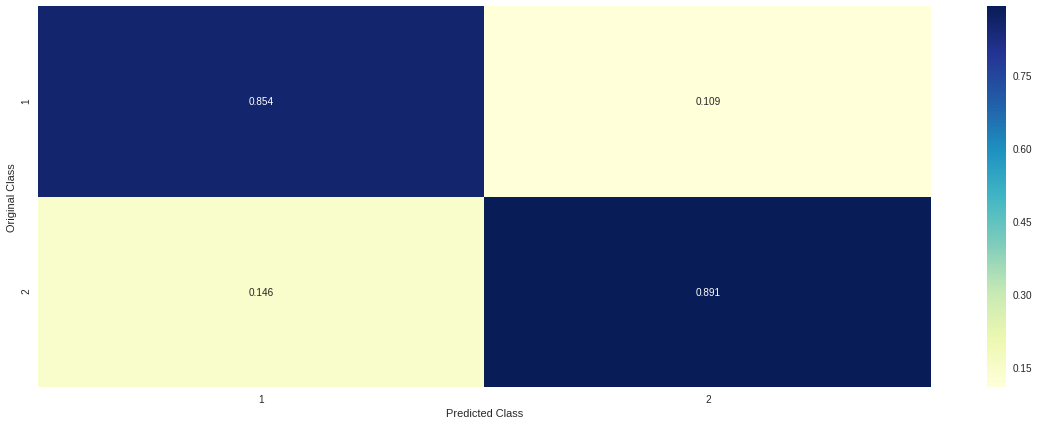

-------------------- Recall matrix (Row sum=1) --------------------


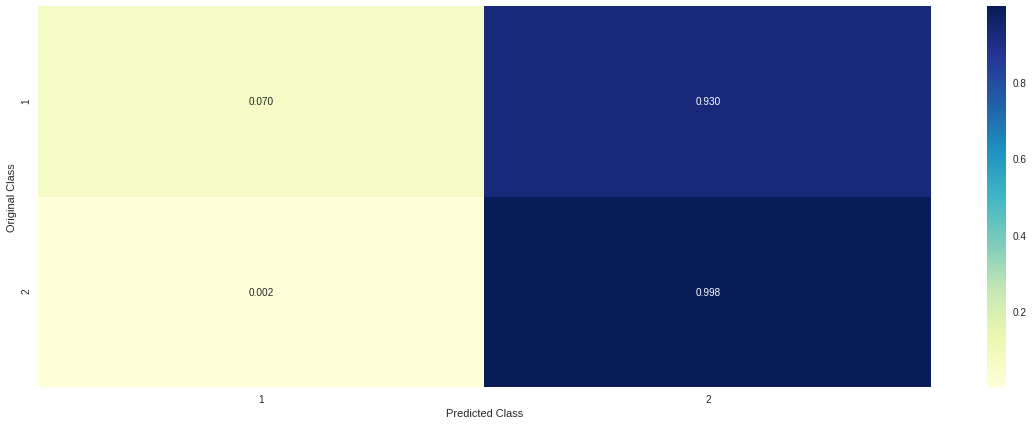

In [133]:
plot_confusion_matrix(Y_test,Y_predict_linear_word2vec)

RBF WORD2VEC

In [134]:
tuned_parameters = [{'C': [10**-4,10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3,10**4]}]
cv_scores = []
clf_word2vec_rbf = SVC(kernel='rbf',gamma='auto')
model_rbf_word2vec = GridSearchCV(clf_word2vec_rbf, tuned_parameters, cv=3,return_train_score='True',scoring='roc_auc')
model_rbf_word2vec.fit(X_train_vect_norm_word2vec, Y_train)
print(model_rbf_word2vec)
print(model_rbf_word2vec.best_estimator_)
print(model_rbf_word2vec.score(X_test_vect_norm_word2vec, Y_test))


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8764556117428814


In [0]:
cv_word2vec_train_rbf = model_rbf_word2vec.cv_results_['mean_train_score']
cv_word2vec_cv_rbf=model_rbf_word2vec.cv_results_['mean_test_score']

In [0]:
cv_word2vec_train_rbf=cv_word2vec_train_rbf.tolist()
cv_word2vec_cv_rbf=cv_word2vec_cv_rbf.tolist()

In [137]:
print(cv_word2vec_train_rbf)
print(cv_word2vec_cv_rbf)

[0.8527915528561328, 0.8702072945304377, 0.8816406668256628, 0.8885725130732567, 0.8934499884903012, 0.8935756670079916, 0.8943899115984627, 0.90338214464828, 0.9175375071751795]
[0.8506895886090344, 0.8675918545324672, 0.8778844462944416, 0.8830410789563258, 0.8862502600839313, 0.8865645298858862, 0.8869099386714896, 0.8846294739805598, 0.8787471391636522]


In [138]:
tuned_parameters_dict=tuned_parameters[0]
print(tuned_parameters_dict['C'])
tuned_parameters_list=tuned_parameters_dict['C']

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [139]:
optimal_C_train_rbf_word2vec = tuned_parameters_list[cv_word2vec_train_rbf.index(max(cv_word2vec_train_rbf))]
optimal_C_cv_rbf_word2vec=tuned_parameters_list[cv_word2vec_cv_rbf.index(max(cv_word2vec_cv_rbf))]
print("'\nThe optimal value of C for training data %d.' ",  optimal_C_train_rbf_word2vec)
print("'\nThe optimal value of C for cv data %d.' ",  optimal_C_cv_rbf_word2vec)

'
The optimal value of C for training data %d.'  10000
'
The optimal value of C for cv data %d.'  100


In [140]:
grid_auc_df = pd.DataFrame(
    {'C value': tuned_parameters_list,
     'AUC Train': cv_word2vec_train_rbf,
     'AUC Cv': cv_word2vec_cv_rbf
    })
grid_auc_df

,AUC Cv,AUC Train,C value
0,0.850690,0.852792,0.0001
1,0.867592,0.870207,0.0010
2,0.877884,0.881641,0.0100
3,0.883041,0.888573,0.1000
4,0.886250,0.893450,1.0000
5,0.886565,0.893576,10.0000
6,0.886910,0.894390,100.0000
7,0.884629,0.903382,1000.0000
8,0.878747,0.917538,10000.0000


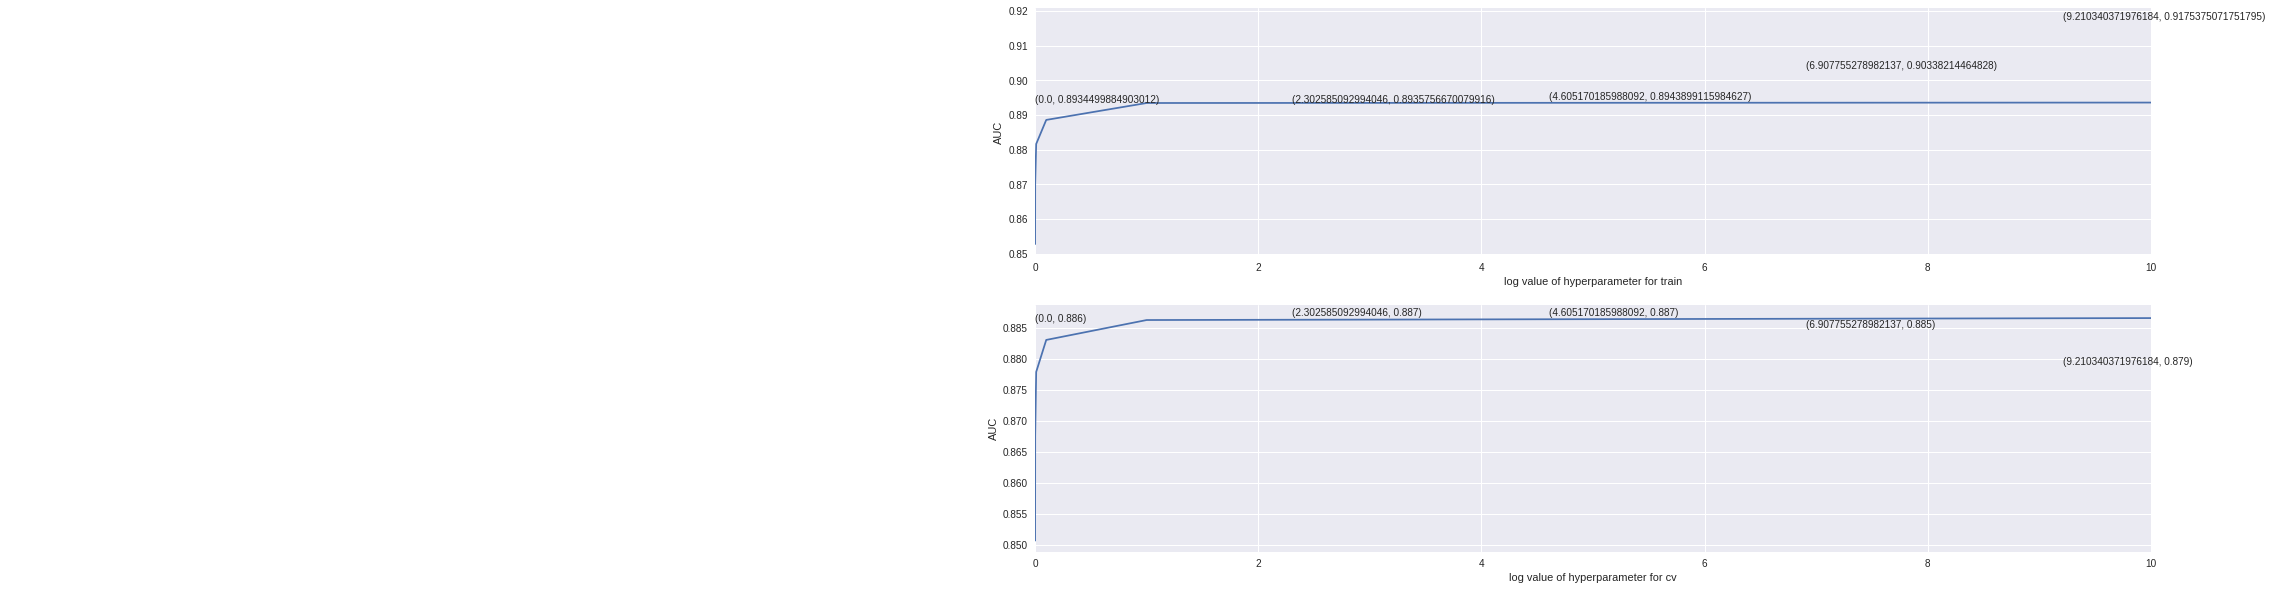

In [141]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(tuned_parameters_list, cv_word2vec_train_rbf)
plt.xlim([0, 10])
#plt.ylim([-0.7, 0])

for xy in zip(tuned_parameters_list_log, (cv_word2vec_train_rbf)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log value of hyperparameter for train')
plt.ylabel('AUC')

    
plt.subplot(2, 1, 2)    
plt.plot(tuned_parameters_list, cv_word2vec_cv_rbf)    
for xy in zip(tuned_parameters_list_log, np.round(cv_word2vec_cv_rbf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlim([0, 10])

plt.xlabel('log value of hyperparameter for cv')
plt.ylabel('AUC')
plt.show()

In [142]:
clf_model_word2vec_rbf=SVC(kernel='rbf',gamma='auto',C=100)
clf_model_word2vec_rbf.fit(X_train_vect_norm_word2vec, Y_train)
Y_predict_rbf_word2vec=clf_model_word2vec_rbf.predict(X_test_vect_norm_word2vec)
Y_conf_rbf_word2vec=clf_model_word2vec_rbf.decision_function(X_test_vect_norm_word2vec)
acc = clf_model_word2vec_rbf.score(X_test_vect_norm_word2vec, Y_test)
print(acc)

0.8951895189518951


In [143]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_conf_rbf_word2vec)
metrics.auc(fpr, tpr)

0.8764556117428814

-------------------- Confusion matrix --------------------


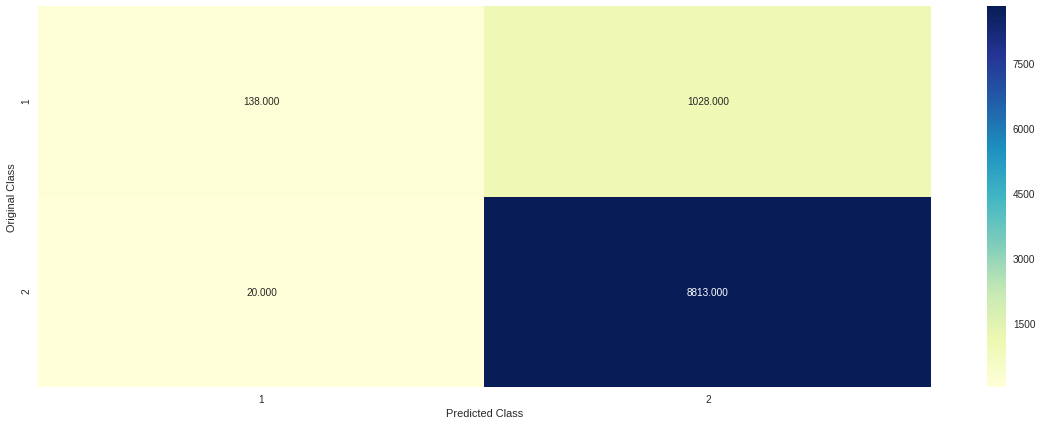

-------------------- Precision matrix (Columm Sum=1) --------------------


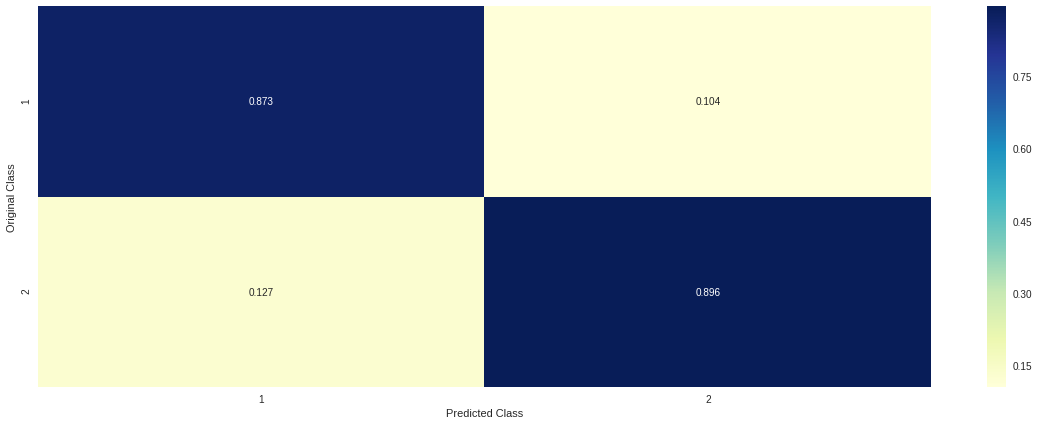

-------------------- Recall matrix (Row sum=1) --------------------


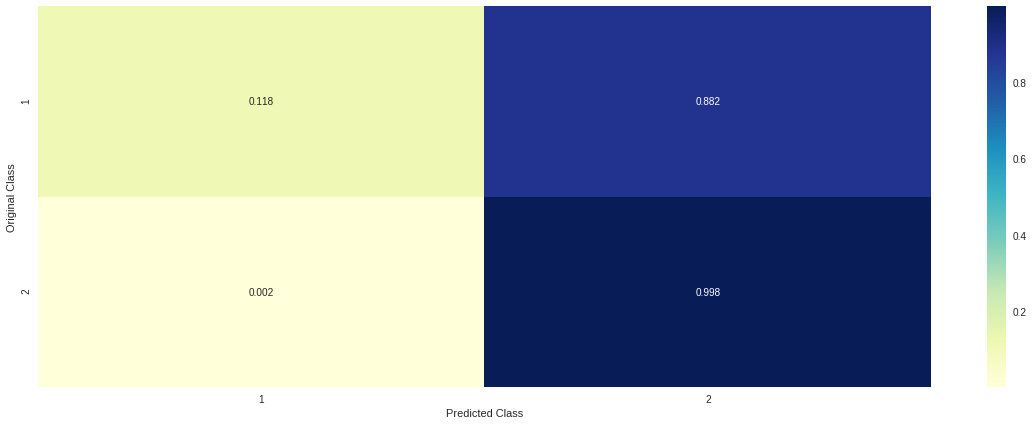

In [144]:
plot_confusion_matrix(Y_test,Y_predict_rbf_word2vec)


# tfidf word2vec

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
        
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
    #print(sent_vec)
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [45]:
from sklearn.preprocessing import Normalizer
transformer_tfidfword2vec = Normalizer().fit(tfidf_sent_vectors_train)
print(transformer_word2vec)
tfidf_sent_vectors_train_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_train)


Normalizer(copy=True, norm='l2')


In [0]:
tfidf_sent_vectors_test_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_test)

tfidfword2vec Linear kernal

In [47]:
tuned_parameters = [{'alpha': [10**-4,10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3,10**4]}]
cv_scores = []
clf_tfidfword2vec = linear_model.SGDClassifier(loss='hinge', penalty='l2')
model_auc_tfidfword2vec = GridSearchCV(clf_tfidfword2vec, tuned_parameters, cv=10,return_train_score='True',scoring='roc_auc')
model_auc_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)
print(model_auc_tfidfword2vec)
print(model_auc_tfidfword2vec.best_estimator_)
print(model_auc_tfidfword2vec.score(tfidf_sent_vectors_test_norm, Y_test))
cv_auc_train_tfidfword2vec = model_auc_tfidfword2vec.cv_results_['mean_train_score']
cv_auc_cv_tfidfword2vec=model_auc_tfidfword2vec.cv_results_['mean_test_score']

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)
SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power

In [0]:
cv_auc_train_tfidfword2vec=cv_auc_train_tfidfword2vec.tolist()
cv_auc_cv_tfidfword2vec=cv_auc_cv_tfidfword2vec.tolist()

In [151]:
tuned_parameters_dict=tuned_parameters[0]
print(tuned_parameters_dict['alpha'])
tuned_parameters_list=tuned_parameters_dict['alpha']
print(tuned_parameters_list)

optimal_alpha_train_tfidfword2vec = tuned_parameters_list[cv_auc_train_tfidfword2vec.index(max(cv_auc_train_tfidfword2vec))]
optimal_alpha_cv_tfidfword2vec=tuned_parameters_list[cv_auc_cv_tfidfword2vec.index(max(cv_auc_cv_tfidfword2vec))]

print("'\nThe optimal value of alpha for training data %d.' ",  optimal_alpha_train_tfidfword2vec)
print("'\nThe optimal value of alpha for cv data %d.' ",  optimal_alpha_cv_tfidfword2vec)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
'
The optimal value of alpha for training data %d.'  0.01
'
The optimal value of alpha for cv data %d.'  0.01


In [152]:
grid_auc_df = pd.DataFrame(
    {'Alpha value': tuned_parameters_list,
     'AUC Train': cv_auc_train_tfidfword2vec,
     'AUC Cv': cv_auc_cv_tfidfword2vec
    })
grid_auc_df

,AUC Cv,AUC Train,Alpha value
0,0.844823,0.846699,0.0001
1,0.846449,0.850290,0.0010
2,0.848782,0.850714,0.0100
3,0.846165,0.849807,0.1000
4,0.841074,0.847687,1.0000
5,0.816596,0.817418,10.0000
6,0.538641,0.538897,100.0000
7,0.538641,0.538897,1000.0000
8,0.538641,0.538897,10000.0000


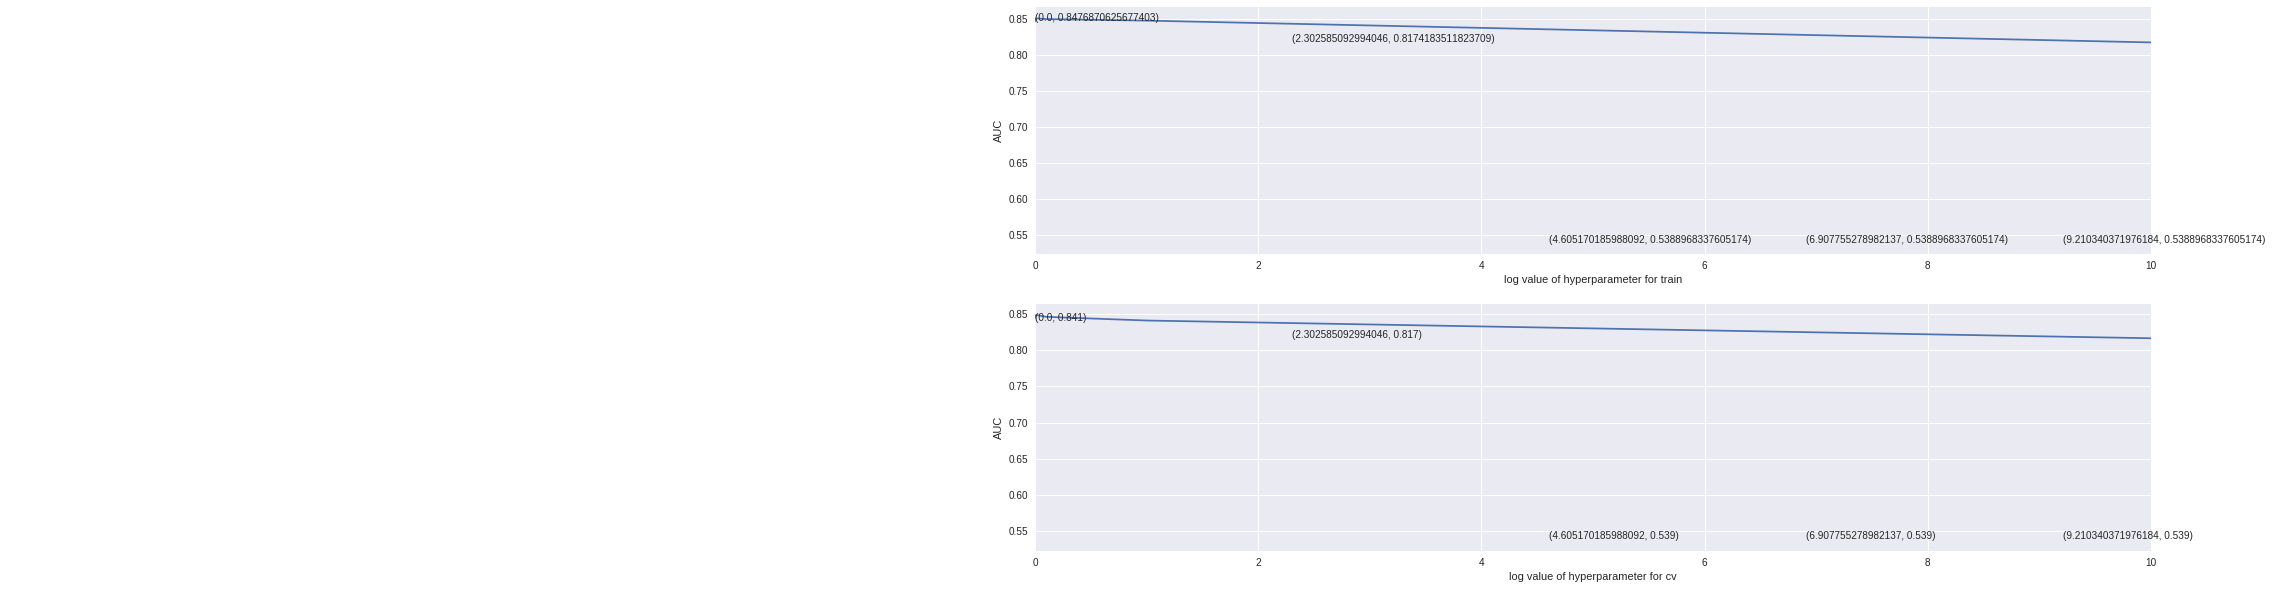

In [153]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(tuned_parameters_list, cv_auc_train_tfidfword2vec)
plt.xlim([0, 10])
#plt.ylim([-0.7, 0])

for xy in zip(tuned_parameters_list_log, (cv_auc_train_tfidfword2vec)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log value of hyperparameter for train')
plt.ylabel('AUC')

    
plt.subplot(2, 1, 2)    
plt.plot(tuned_parameters_list, cv_auc_cv_tfidfword2vec)    
for xy in zip(tuned_parameters_list_log, np.round(cv_auc_cv_tfidfword2vec,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlim([0, 10])

plt.xlabel('log value of hyperparameter for cv')
plt.ylabel('AUC')
plt.show()

In [185]:
clf_model_tfidfword2vec=linear_model.SGDClassifier(loss='hinge', penalty='l2',alpha=0.00001)
clf_model_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)

Y_predict_tfidfword2vec=clf_model_tfidfword2vec.predict(tfidf_sent_vectors_test_norm)


Y_conf_tfidfword2vec=clf_model_tfidfword2vec.decision_function(tfidf_sent_vectors_test_norm)
acc = clf_model_tfidfword2vec.score(tfidf_sent_vectors_test_norm, Y_test)
print(acc)

0.8918891889188919


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [186]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_conf_tfidfword2vec)
metrics.auc(fpr, tpr)

0.8227709748197884

-------------------- Confusion matrix --------------------


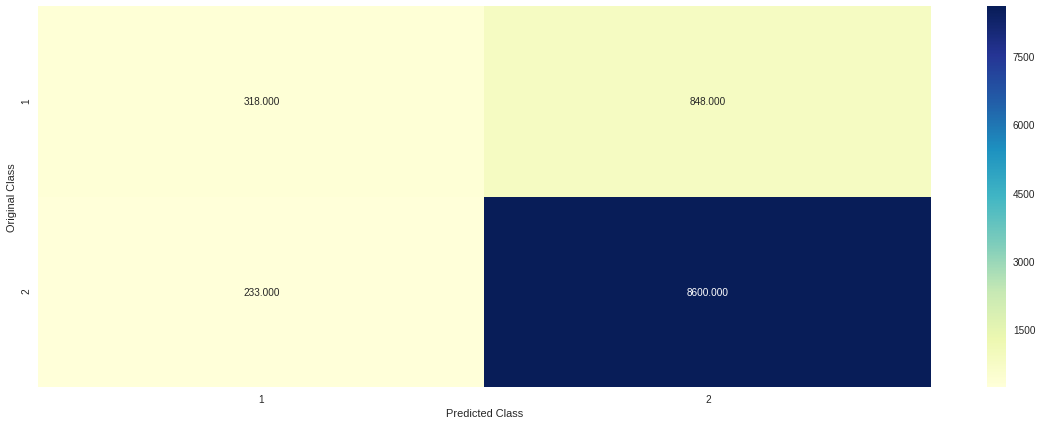

-------------------- Precision matrix (Columm Sum=1) --------------------


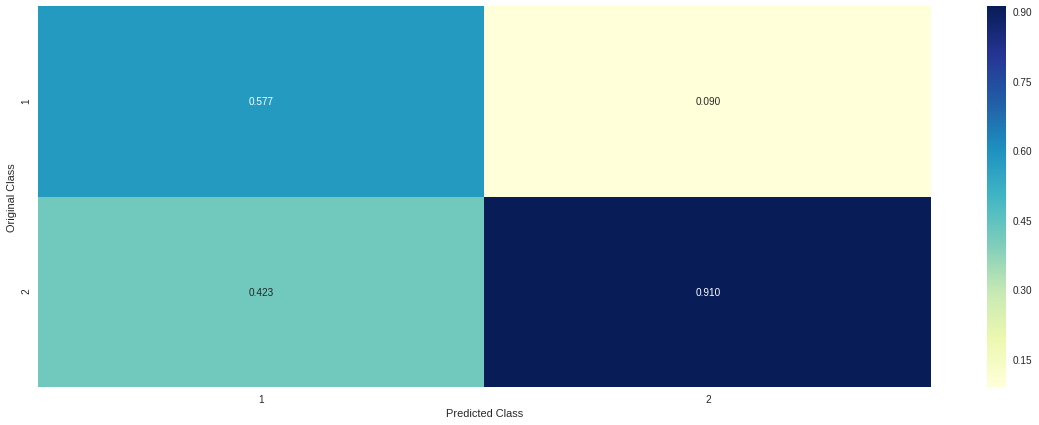

-------------------- Recall matrix (Row sum=1) --------------------


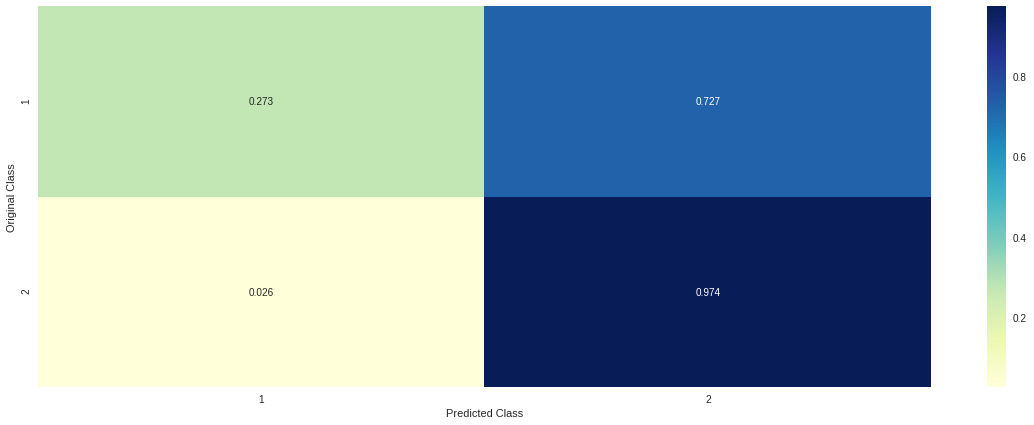

In [187]:
plot_confusion_matrix(Y_test,Y_predict_tfidfword2vec)

TFIDFWORD2VEC RBF KERNAL

In [165]:
tuned_parameters = [{'C': [10**-4,10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3,10**4]}]
cv_scores = []
clf_tfidfword2vec_rbf = SVC(kernel='rbf',gamma='auto')
model_rbf_tfidfword2vec = GridSearchCV(clf_tfidfword2vec_rbf, tuned_parameters, cv=3,return_train_score='True',scoring='roc_auc')
model_rbf_tfidfword2vec.fit(tfidf_sent_vectors_train_norm, Y_train)
print(model_rbf_word2vec)
print(model_rbf_word2vec.best_estimator_)
print(model_rbf_word2vec.score(tfidf_sent_vectors_test_norm, Y_test))

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
       scoring='roc_auc', verbose=0)
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8451338045249385


In [0]:
cv_tfidfword2vec_train_rbf = model_rbf_tfidfword2vec.cv_results_['mean_train_score']
cv_tfidfword2vec_cv_rbf=model_rbf_tfidfword2vec.cv_results_['mean_test_score']

In [0]:
cv_tfidfword2vec_train_rbf=cv_tfidfword2vec_train_rbf.tolist()
cv_tfidfword2vec_cv_rbf=cv_tfidfword2vec_cv_rbf.tolist()

In [168]:
print(cv_tfidfword2vec_train_rbf)
print(cv_tfidfword2vec_cv_rbf)

[0.8233287771504282, 0.8449004471268404, 0.8559269150598343, 0.8481454656151112, 0.8754961024713307, 0.8789074830186859, 0.8790373568706977, 0.8854837840010269, 0.9053794577824222]
[0.8211783363158585, 0.8419762856332527, 0.8505790192676773, 0.841115901898988, 0.8556526241137874, 0.8603210039704589, 0.8605760860162944, 0.861095508639666, 0.8589533316918714]


In [169]:
tuned_parameters_dict=tuned_parameters[0]
print(tuned_parameters_dict['C'])
tuned_parameters_list=tuned_parameters_dict['C']

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


In [170]:
optimal_C_train_rbf_tfidfword2vec = tuned_parameters_list[cv_tfidfword2vec_train_rbf.index(max(cv_tfidfword2vec_train_rbf))]
optimal_C_cv_rbf_tfidfword2vec=tuned_parameters_list[cv_tfidfword2vec_cv_rbf.index(max(cv_tfidfword2vec_cv_rbf))]
print("'\nThe optimal value of C for training data %d.' ",  optimal_C_train_rbf_tfidfword2vec)
print("'\nThe optimal value of C for cv data %d.' ",  optimal_C_cv_rbf_tfidfword2vec)

'
The optimal value of C for training data %d.'  10000
'
The optimal value of C for cv data %d.'  1000


In [171]:
grid_auc_df = pd.DataFrame(
    {'C value': tuned_parameters_list,
     'AUC Train': cv_tfidfword2vec_train_rbf,
     'AUC Cv': cv_tfidfword2vec_cv_rbf
    })
grid_auc_df

,AUC Cv,AUC Train,C value
0,0.821178,0.823329,0.0001
1,0.841976,0.844900,0.0010
2,0.850579,0.855927,0.0100
3,0.841116,0.848145,0.1000
4,0.855653,0.875496,1.0000
5,0.860321,0.878907,10.0000
6,0.860576,0.879037,100.0000
7,0.861096,0.885484,1000.0000
8,0.858953,0.905379,10000.0000


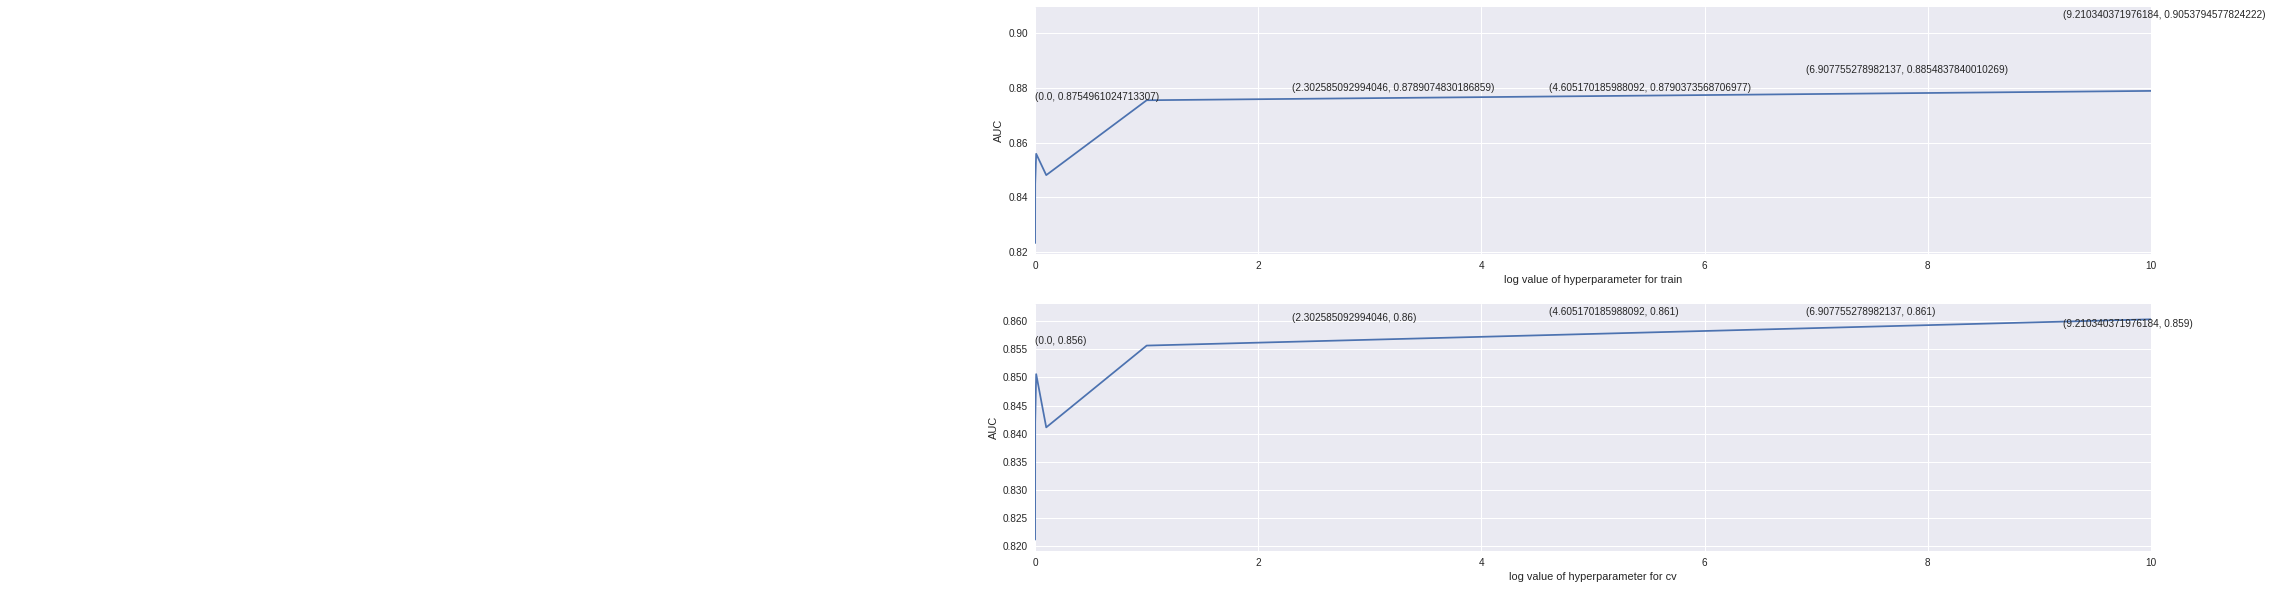

In [172]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(tuned_parameters_list, cv_tfidfword2vec_train_rbf)
plt.xlim([0, 10])
#plt.ylim([-0.7, 0])

for xy in zip(tuned_parameters_list_log, (cv_tfidfword2vec_train_rbf)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log value of hyperparameter for train')
plt.ylabel('AUC')

    
plt.subplot(2, 1, 2)    
plt.plot(tuned_parameters_list, cv_tfidfword2vec_cv_rbf)    
for xy in zip(tuned_parameters_list_log, np.round(cv_tfidfword2vec_cv_rbf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlim([0, 10])

plt.xlabel('log value of hyperparameter for cv')
plt.ylabel('AUC')
plt.show()

In [173]:
clf_model_tfidfword2vec_rbf=SVC(kernel='rbf',gamma='auto',C=1000)
clf_model_tfidfword2vec_rbf.fit(tfidf_sent_vectors_train_norm, Y_train)
Y_predict_tfidfword2vec=clf_model_tfidfword2vec_rbf.predict(tfidf_sent_vectors_test_norm)
Y_conf_tfidfword2vec=clf_model_tfidfword2vec_rbf.decision_function(tfidf_sent_vectors_test_norm)

acc = clf_model_tfidfword2vec_rbf.score(tfidf_sent_vectors_test_norm, Y_test)
print(acc)

0.8961896189618962


In [174]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_conf_tfidfword2vec)
metrics.auc(fpr, tpr)

0.8426112005132788

-------------------- Confusion matrix --------------------


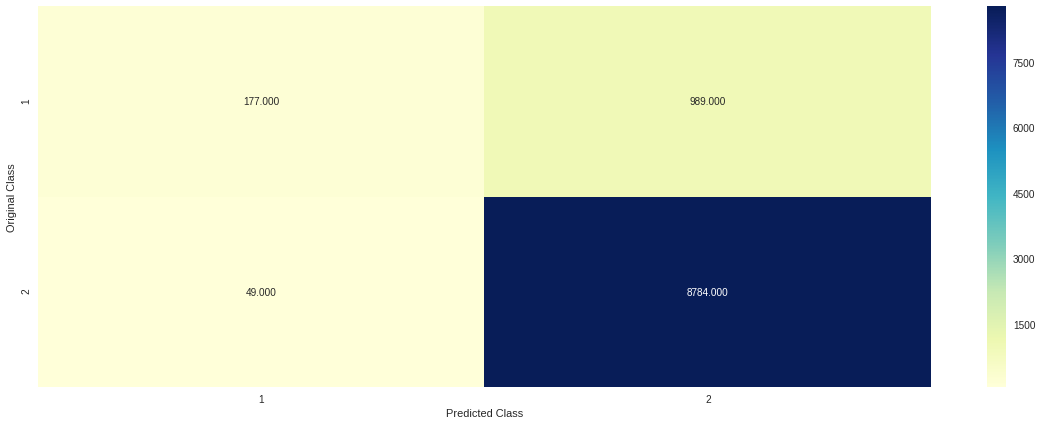

-------------------- Precision matrix (Columm Sum=1) --------------------


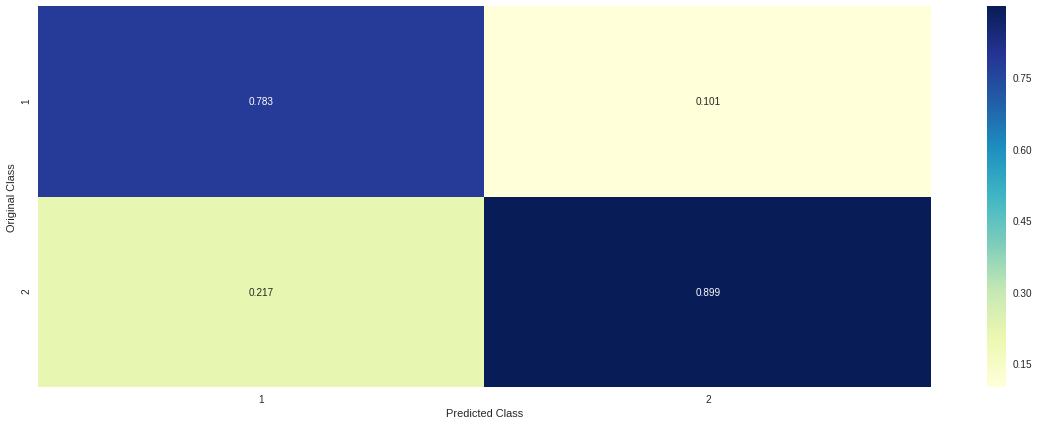

-------------------- Recall matrix (Row sum=1) --------------------


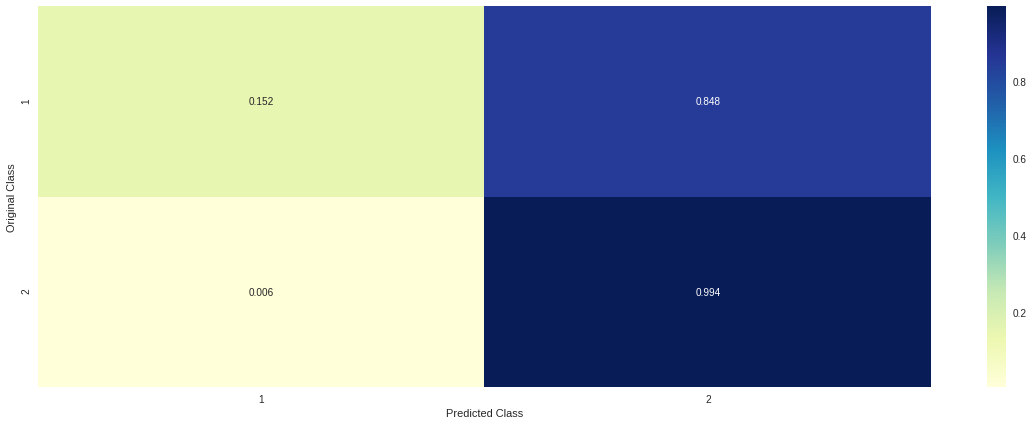

In [175]:
plot_confusion_matrix(Y_test,Y_predict_tfidfword2vec)

Conclusion

In [0]:
from prettytable import PrettyTable
x = PrettyTable()

In [0]:
x.field_names = ["Type of vectorizer", "Linear kernel AUC","Linear kernel best hyperparameter","RBF kernel AUC","RBF kernel best hyperparameter"]

In [0]:
x.add_row(["TFIDF","0.905","0.0001","0.8918","10000"])
x.add_row(["BOW","0.8708","0.0001","0.875","10"])
x.add_row(["WORD2VEC","0.869","0.0001","0.876","100"])
x.add_row(["TFIDF WORD2VEC","0.822","0.0001","0.842","1000"])

In [191]:
print(x)

+--------------------+-------------------+-----------------------------------+----------------+--------------------------------+
| Type of vectorizer | Linear kernel AUC | Linear kernel best hyperparameter | RBF kernel AUC | RBF kernel best hyperparameter |
+--------------------+-------------------+-----------------------------------+----------------+--------------------------------+
|       TFIDF        |       0.905       |               0.0001              |     0.8918     |             10000              |
|        BOW         |       0.8708      |               0.0001              |     0.875      |               10               |
|      WORD2VEC      |       0.869       |               0.0001              |     0.876      |              100               |
|   TFIDF WORD2VEC   |       0.822       |               0.0001              |     0.842      |              1000              |
+--------------------+-------------------+-----------------------------------+----------------+--